# Asset Allocation: Morolli-Lombardi
## Import libraries and data cleaning
First of all, we imported the necessary libraries to work with panel data and data frames, such as pandas and NumPy, and to create plots, like matplotlib. Moreover, we import SciPy libraries to create the optimization function to identify the efficient frontier and to deal with random variables and distribution.\
Then we cleaned the dataset, removing duplicate and missing vectors from the two-time frame (such as Poste Italiane and Gambero Rosso).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import scipy.optimize as spo
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import pandas_profiling as pp
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
sns.despine()

<Figure size 432x288 with 0 Axes>

Now we proceed in creating the data frame based on the CSV file containing the market data.

In [2]:
monthly=pd.read_csv("/monthly.csv",sep=";")
daily=pd.read_csv("/daily.csv", sep=";")
ftsemib_Daily=pd.read_csv("/mibD.csv",";")
ftsemib_Monthly=pd.read_csv("/mibM.csv",";")
monthly.set_index("TIME")
daily.set_index("TIME")





,LEO0RDO,ECOSUNTEK,LANDI RENZO,STELLANTIS,PININFARI0,FRENI BREMBO,INTESA SANPAOLO,UNICREDIT,BANCA GENERALI,BPER BANCA,FINECOBANK SPA,DAVIDE CAMPARI MILANO,CALTAGIRONE,ASTALDI,ENEL,ALERION CLEAN POWER,A2A,TER0 RETE ELETTRICA 0Z,ACEA,DEA CAPITAL,BANCA MEDIOLANUM,BANCA INTERMOBILIARE,TAMBURI INV.PARTNERS,MEDIOBANCA BC.FIN,ANIMA HOLDING,TELECOM ITALIA RSP,TELECOM ITALIA,ENERVIT,VALSOIA,CENTRALE DEL LATTE D'ITALIA,HERA,IREN,ITALGAS,EL EN,AMPLIFON,DE LONGHI,BORGOSESIA RSP,CNH INDUSTRIAL,FIDIA,INTERPUMP GROUP,...,CATTOLICA ASSICURAZIONI,RIZZOLI CRER.DLSM.GP.,CAIRO COMMUNICATION,MONRIF,UNIPOL GRUPPO FI0NZIARI,ASSICURAZIONI GENERALI,S0M,ENI,TOD'S,RECORDATI INDUA.CHIMICA,RISA0MENTO,BRIOSCHI SVILUPPO IMMBL,FULLSIX,EXPRIVIA,AUTOGRILL,JUVENTUS FOOTBALL CLUB,SS LAZIO,CLASS EDITORI,BASTOGI,CEMENTIR HOLDING,UNIPOLSAI,BUZZI UNICEM,CREDITO EMILIANO,DANIELI,ITALMOBILIARE,VINCENZO ZUCCHI,WEBUILD,VIANINI INDR.,EDISON RSP,RATTI,GABETTI PROPERTY SLTN.,MEDIASET,ERG,CEMBRE,SABAF,BEGHELLI,SOL,DATALOGIC,BIESSE,SAFILO GROUP
TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01/01/2015,7.735,13.6,0.9900,4.9744,2.2126,5.540,2.4220,25.1131,23.05,3.6992,4.668,2.5800,1.916,4.7800,3.696,2.816,0.8375,3.760,8.940,1.621,5.290,1.6805,2.624,6.770,3.9456,0.6935,0.8820,3.34,15.16,2.684,1.945,0.9055,0.000,6.6325,4.904,14.97,0.853,6.700,2.894,11.65,...,5.725,0.9345,4.854,0.2847,4.120,17.000,3.3841,14.510,72.00,12.85,0.0990,0.0918,1.714,0.7145,5.5284,0.2026,0.4950,0.9207,2.252,5.015,2.234,10.51,6.230,20.58,9.400,5.30,3.016,1.18,0.854,2.400,0.8245,3.440,9.255,10.21,11.17,0.4015,6.655,8.90,9.36,6.6689
02/01/2015,7.730,13.6,0.9920,5.0132,2.2533,5.566,2.4540,25.5838,23.30,3.7770,4.740,2.5225,1.850,4.8120,3.680,2.832,0.8355,3.746,9.110,1.675,5.360,1.6805,2.626,6.865,3.9512,0.6965,0.8760,3.44,15.46,2.698,1.941,0.9260,0.000,7.0500,4.900,14.90,0.853,6.585,2.910,11.97,...,5.815,0.9695,4.952,0.2836,4.176,17.040,3.3642,14.590,72.05,13.06,0.0990,0.0898,1.706,0.7030,5.6478,0.2053,0.4930,0.9300,2.244,5.230,2.240,10.50,6.330,20.57,9.500,5.25,3.068,1.22,0.860,2.400,0.8180,3.432,9.410,10.40,11.17,0.3985,6.665,8.88,9.57,6.7679
05/01/2015,7.430,13.6,0.9955,4.9044,2.2083,5.510,2.3080,23.8892,22.89,3.5909,4.652,2.4650,1.850,4.6300,3.442,2.830,0.8080,3.624,8.990,1.670,5.220,1.6796,2.590,6.565,3.9361,0.6795,0.8500,3.50,15.36,2.752,1.921,0.9120,0.000,7.1125,5.025,15.19,0.850,6.245,2.980,11.85,...,5.620,0.9510,4.808,0.2770,4.000,16.430,3.2520,13.370,69.45,13.25,0.1000,0.0887,1.705,0.6980,5.5417,0.2047,0.4964,0.9012,2.320,5.070,2.172,9.97,6.365,20.42,9.250,5.20,2.980,1.27,0.850,2.320,0.7960,3.262,9.110,10.43,11.11,0.3950,6.730,8.84,9.96,6.5700
06/01/2015,7.350,13.6,0.9850,4.9822,2.2027,5.422,2.2760,23.5597,22.68,3.4555,4.600,2.5225,1.851,4.5200,3.492,2.800,0.7960,3.600,8.900,1.680,5.190,1.6805,2.574,6.475,3.9152,0.6830,0.8575,3.49,15.43,2.758,1.947,0.8960,0.000,7.3150,5.025,14.98,0.850,6.395,2.962,11.68,...,5.580,0.9110,4.720,0.2820,3.920,16.500,3.2371,13.550,70.05,13.10,0.1000,0.0897,1.705,0.7020,5.3604,0.2035,0.5005,0.8985,2.320,5.000,2.170,9.75,6.350,20.30,8.995,5.26,2.838,1.27,0.850,2.380,0.7960,3.172,9.090,10.59,11.05,0.3910,6.710,8.80,10.39,6.4277
07/01/2015,7.465,13.6,0.9925,5.0262,2.2196,5.364,2.2480,23.3290,22.45,3.3776,4.516,2.5475,1.888,4.4100,3.486,2.826,0.7915,3.584,8.995,1.680,5.135,1.6805,2.590,6.475,3.8792,0.6810,0.8510,3.50,15.38,2.726,1.930,0.8945,0.000,7.2500,5.160,14.73,0.850,6.390,3.050,11.46,...,5.500,0.8970,4.710,0.2849,3.834,16.540,3.2388,13.620,70.45,12.99,0.1013,0.0899,1.709,0.6960,5.3781,0.2006,0.5015,0.8700,2.246,5.245,2.170,10.05,6.350,20.18,9.150,5.17,2.740,1.24,0.845,2.366,0.7995,3.176,9.105,10.43,10.94,0.3930,6.860,8.85,10.14,6.4957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Compute return
We need stationarity to manipulate and model the data, so we need to compute the periodic return for each asset.
To do so we compute the percentage change from one period to the next one. This DataFrame method is equivalent to the log first difference.

In [3]:
asset=list(monthly.columns.values)
asset.pop(0)

monthly_return=pd.DataFrame()
for i in asset:
  monthly_return[i]=monthly[i].pct_change()
print(monthly_return)

asset_d=list(daily.columns.values)
asset_d.pop(0)
daily_return=pd.DataFrame()
for c in asset_d:
  daily_return[c]=daily[c].pct_change()
print(daily_return)


     LEO0RDO  ECOSUNTEK  LANDI RENZO  ...  DATALOGIC    BIESSE  SAFILO GROUP
0        NaN        NaN          NaN  ...        NaN       NaN           NaN
1   0.248222   0.018382     0.055556  ...   0.138202  0.356838      0.197589
2   0.121699   0.002888    -0.020096  ...   0.041461  0.300000      0.078244
3   0.048938  -0.015839     0.113281  ...   0.036019 -0.052695      0.037357
4   0.007923  -0.136796    -0.050000  ...   0.056725 -0.079284     -0.098341
..       ...        ...          ...  ...        ...       ...           ...
73 -0.032149   0.006329     0.163814  ...   0.026429  0.046734      0.101631
74  0.204545   0.037736     0.160714  ...   0.195546  0.161847      0.078588
75  0.018578  -0.042424    -0.024434  ...   0.018044  0.044541     -0.026399
76 -0.020234   0.006329    -0.044527  ...  -0.009148  0.033445      0.160521
77  0.043921   0.031447    -0.043689  ...   0.268321  0.208738      0.519626

[78 rows x 81 columns]
       LEO0RDO  ECOSUNTEK  LANDI RENZO  ...  DATALOG

## Compute descriptive statistics


In [ ]:
stats = monthly_return.describe()
stats.loc["Variance"] = monthly_return.var().tolist()
stats.loc["Skewness"] = monthly_return.skew().tolist()
stats.loc["Kurtosis"] = monthly_return.kurtosis().tolist()
print("Monthly return summary statistics")
stats



In [ ]:
print("Daily return summary statistics")
stats = daily_return.describe()
stats.loc["Variance"] = daily_return.var().tolist()
stats.loc["Skewness"] = daily_return.skew().tolist()
stats.loc["Kurtosis"] = daily_return.kurtosis().tolist()
stats

Daily return summary statistics


,LEO0RDO,ECOSUNTEK,LANDI RENZO,STELLANTIS,PININFARI0,FRENI BREMBO,INTESA SANPAOLO,UNICREDIT,BANCA GENERALI,BPER BANCA,FINECOBANK SPA,DAVIDE CAMPARI MILANO,CALTAGIRONE,ASTALDI,ENEL,ALERION CLEAN POWER,A2A,TER0 RETE ELETTRICA 0Z,ACEA,DEA CAPITAL,BANCA MEDIOLANUM,BANCA INTERMOBILIARE,TAMBURI INV.PARTNERS,MEDIOBANCA BC.FIN,ANIMA HOLDING,TELECOM ITALIA RSP,TELECOM ITALIA,ENERVIT,VALSOIA,CENTRALE DEL LATTE D'ITALIA,HERA,IREN,ITALGAS,EL EN,AMPLIFON,DE LONGHI,BORGOSESIA RSP,CNH INDUSTRIAL,FIDIA,INTERPUMP GROUP,...,CATTOLICA ASSICURAZIONI,RIZZOLI CRER.DLSM.GP.,CAIRO COMMUNICATION,MONRIF,UNIPOL GRUPPO FI0NZIARI,ASSICURAZIONI GENERALI,S0M,ENI,TOD'S,RECORDATI INDUA.CHIMICA,RISA0MENTO,BRIOSCHI SVILUPPO IMMBL,FULLSIX,EXPRIVIA,AUTOGRILL,JUVENTUS FOOTBALL CLUB,SS LAZIO,CLASS EDITORI,BASTOGI,CEMENTIR HOLDING,UNIPOLSAI,BUZZI UNICEM,CREDITO EMILIANO,DANIELI,ITALMOBILIARE,VINCENZO ZUCCHI,WEBUILD,VIANINI INDR.,EDISON RSP,RATTI,GABETTI PROPERTY SLTN.,MEDIASET,ERG,CEMBRE,SABAF,BEGHELLI,SOL,DATALOGIC,BIESSE,SAFILO GROUP
count,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1201.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,...,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,0.000253,0.000171,0.000522,0.001049,0.000401,0.000588,0.000242,-0.000127,0.000434,0.000093,0.000852,0.000998,0.000622,-0.000621,0.000594,0.001252,0.000584,0.000428,0.000635,0.000021,0.000468,-0.001565,0.000802,0.000476,0.000397,0.000039,-0.000145,0.000201,0.000200,0.000341,0.000499,0.000762,inf,0.001416,0.001453,0.000781,0.000886,0.000716,0.000429,0.001045,...,0.000380,0.000263,-0.000323,-0.000332,0.000311,0.000139,0.000356,-0.000008,-0.000025,0.000933,0.000971,0.000336,0.000270,0.000880,0.000351,0.001150,0.000930,-0.000832,-0.000258,0.000613,0.000206,0.000691,0.000094,0.000272,0.000870,0.000226,0.000102,0.000075,0.000271,0.000484,0.000684,0.000183,0.000767,0.000639,0.000674,0.000221,0.000710,0.000810,0.001056,-0.000379
std,0.024139,0.031246,0.032295,0.025128,0.039359,0.019578,0.021515,0.027456,0.019474,0.029891,0.020084,0.015968,0.016849,0.041032,0.015807,0.024569,0.016343,0.013934,0.016022,0.015292,0.020111,0.035104,0.016259,0.022045,0.025185,0.021748,0.022475,0.018687,0.018729,0.020252,0.015209,0.015598,NaN,0.023864,0.019503,0.020130,0.030289,0.022972,0.032754,0.018801,...,0.022871,0.027101,0.020645,0.026876,0.022469,0.016286,0.015292,0.018358,0.020779,0.017464,0.035553,0.024117,0.032716,0.029141,0.023169,0.027057,0.027041,0.030993,0.024150,0.021717,0.016854,0.020707,0.018389,0.020536,0.018145,0.039101,0.025503,0.016681,0.013700,0.019762,0.027383,0.023899,0.017104,0.016952,0.017708,0.022931,0.017734,0.024487,0.027723,0.029035
min,-0.221500,-0.173469,-0.204082,-0.178640,-0.688112,-0.116913,-0.229407,-0.237881,-0.137833,-0.246101,-0.121635,-0.161145,-0.105263,-0.345616,-0.198466,-0.158242,-0.190419,-0.149458,-0.139175,-0.159222,-0.150492,-0.415481,-0.135932,-0.212166,-0.151114,-0.179747,-0.184700,-0.178333,-0.095128,-0.110106,-0.174763,-0.150586,-0.137041,-0.137710,-0.194472,-0.130435,-0.444444,-0.172018,-0.181034,-0.112369,...,-0.168925,-0.147059,-0.145122,-0.150407,-0.185752,-0.167683,-0.191819,-0.208521,-0.114400,-0.164647,-0.205508,-0.157895,-0.232558,-0.167939,-0.210696,-0

We can highlight the lower value for the daily statistics, in particular, the mean daily return is of order $E^{-4}$ while the monthly return of order $E^{-2}$. Moreover, the median of both frequency results, most of the time, negative or equal to zero. The daily return values are distributed between -70% to +50% return (in particular for high volatility assets), while the monthly return can be found in the interval between -50% and +250%.\
Finally, concerning the skewness and the kurtosis is possible to highlight the non-gaussianity of returns distribution, since the values are respectively significantly different from 0 and 3.

In [5]:
def Covariance_matrix(df):
    cov=df.cov()
    return cov

monthly_Cov=Covariance_matrix(monthly_return)

daily_Cov=Covariance_matrix(daily_return)
print("Variance-Covariance matrix (daily data)")
daily_Cov




Variance-Covariance matrix (daily data)


,LEO0RDO,ECOSUNTEK,LANDI RENZO,STELLANTIS,PININFARI0,FRENI BREMBO,INTESA SANPAOLO,UNICREDIT,BANCA GENERALI,BPER BANCA,FINECOBANK SPA,DAVIDE CAMPARI MILANO,CALTAGIRONE,ASTALDI,ENEL,ALERION CLEAN POWER,A2A,TER0 RETE ELETTRICA 0Z,ACEA,DEA CAPITAL,BANCA MEDIOLANUM,BANCA INTERMOBILIARE,TAMBURI INV.PARTNERS,MEDIOBANCA BC.FIN,ANIMA HOLDING,TELECOM ITALIA RSP,TELECOM ITALIA,ENERVIT,VALSOIA,CENTRALE DEL LATTE D'ITALIA,HERA,IREN,ITALGAS,EL EN,AMPLIFON,DE LONGHI,BORGOSESIA RSP,CNH INDUSTRIAL,FIDIA,INTERPUMP GROUP,...,CATTOLICA ASSICURAZIONI,RIZZOLI CRER.DLSM.GP.,CAIRO COMMUNICATION,MONRIF,UNIPOL GRUPPO FI0NZIARI,ASSICURAZIONI GENERALI,S0M,ENI,TOD'S,RECORDATI INDUA.CHIMICA,RISA0MENTO,BRIOSCHI SVILUPPO IMMBL,FULLSIX,EXPRIVIA,AUTOGRILL,JUVENTUS FOOTBALL CLUB,SS LAZIO,CLASS EDITORI,BASTOGI,CEMENTIR HOLDING,UNIPOLSAI,BUZZI UNICEM,CREDITO EMILIANO,DANIELI,ITALMOBILIARE,VINCENZO ZUCCHI,WEBUILD,VIANINI INDR.,EDISON RSP,RATTI,GABETTI PROPERTY SLTN.,MEDIASET,ERG,CEMBRE,SABAF,BEGHELLI,SOL,DATALOGIC,BIESSE,SAFILO GROUP
LEO0RDO,0.000583,0.000076,0.000199,0.000318,0.000161,0.000198,0.000312,0.000366,0.000240,0.000361,0.000223,0.000155,0.000110,0.000211,0.000188,0.000069,0.000182,0.000140,0.000134,0.000117,0.000260,0.000149,0.000165,0.000321,0.000268,0.000232,0.000250,0.000056,0.000108,0.000096,0.000126,0.000136,0.000120,0.000204,0.000142,0.000111,3.260701e-05,0.000299,0.000147,0.000184,...,0.000193,0.000191,0.000181,0.000074,0.000293,0.000234,0.000153,0.000255,0.000150,0.000135,0.000198,0.000118,0.000111,0.000163,0.000287,0.000167,0.000172,0.000194,0.000102,0.000201,0.000195,0.000263,0.000176,0.000167,0.000121,0.000155,0.000243,0.000040,0.000101,0.000080,0.000182,0.000226,0.000143,0.000095,0.000089,0.000116,0.000082,0.000211,0.000252,0.000173
ECOSUNTEK,0.000076,0.000976,0.000059,0.000059,0.000065,0.000061,0.000048,0.000054,0.000043,0.000060,0.000028,0.000017,0.000026,0.000057,0.000033,0.000062,0.000031,0.000027,0.000038,0.000020,0.000050,0.000074,0.000046,0.000055,0.000057,0.000037,0.000041,0.000001,0.000047,0.000020,0.000035,0.000038,0.000030,0.000055,0.000030,0.000018,-1.416607e-05,0.000058,0.000110,0.000059,...,0.000023,0.000032,0.000033,0.000004,0.000056,0.000028,0.000017,0.000043,0.000040,0.000018,0.000047,0.000028,0.000034,0.000088,0.000056,0.000042,0.000032,0.000038,0.000037,0.000039,0.000030,0.000053,0.000034,0.000047,0.000018,0.000003,0.000058,-0.000006,0.000020,0.000034,0.000039,0.000027,0.000029,0.000035,0.000043,0.000044,0.000030,0.000033,0.000062,0.000033
LANDI RENZO,0.000199,0.000059,0.001043,0.000198,0.000126,0.000123,0.000195,0.000243,0.000160,0.000229,0.000183,0.000085,0.000082,0.000175,0.000126,0.000107,0.000131,0.000091,0.000110,0.000104,0.000165,0.000110,0.000125,0.000206,0.000207,0.000143,0.000150,0.000050,0.000107,0.000082,0.000091,0.000125,0.000108,0.000160,0.000116,0.000094,-6.621005e-07,0.000180,0.000166,0.000139,...,0.000131,0.000122,0.000119,0.000050,0.000185,0.000147,0.000114,0.000164,0.000096,0.000111,0.000142,0.000087,0.000106,0.000089,0.000157,0.000140,0.000157,0.000200,0.000115,0.000149,0.000103,0.000158,0.000133,0.000124,0.000075,0.000222,0.000164,0.000009,0.000085,0.000065,0.000137,0.000115,0.000140,0.000072,0.000107,0.000101,0.000069,0.000142,0.000195,0.000113
STELLANTIS,0.000318,0.000059,0.000198,0.000631,0.000207,0.000230,0.000315,0.000365,0.000259,0.000359,0.000238,0.000142,0.000108,0.000250,0.000186,0.000079,0.000171,0.000127,0.000127,0.000131,0.000275,0.000175,0.000178,0.000309,0.000299,0.000230,0.000243,0.000079,0.000108,0.000095,0.000128,0.000128,0.000117,0.000206,0.000153,0.000142,2.778261e-05,0.000334,0.000180,0.000209,...,0.000197,0.000195,0.000178,0.000083,0.000297,0.000231,0.000135,0.000255,0.000164,0.000139,0.000217,0.000117,0.000096,0.000150,0.000229,0.000189,0.000182,0.000241,0.000116,0.000231,0.000207,0.000281,0.000213,0.000169,0.000128,0.000179,0.000238,0.000031,0.000094,0.000088,0.000188,0.000248,0.000152,0.000108,0.000095,0.000136,0.000089,0.000228,0.000301,0.000175
PININFARI0,0.000161,0.000065,0.0

In [6]:
print("Variance-Covariance matrix (monthly data)")
monthly_Cov


Variance-Covariance matrix (monthly data)


,LEO0RDO,ECOSUNTEK,LANDI RENZO,STELLANTIS,PININFARI0,FRENI BREMBO,INTESA SANPAOLO,UNICREDIT,BANCA GENERALI,BPER BANCA,FINECOBANK SPA,DAVIDE CAMPARI MILANO,CALTAGIRONE,ASTALDI,ENEL,ALERION CLEAN POWER,A2A,TER0 RETE ELETTRICA 0Z,ACEA,DEA CAPITAL,BANCA MEDIOLANUM,BANCA INTERMOBILIARE,TAMBURI INV.PARTNERS,MEDIOBANCA BC.FIN,ANIMA HOLDING,TELECOM ITALIA RSP,TELECOM ITALIA,ENERVIT,VALSOIA,CENTRALE DEL LATTE D'ITALIA,HERA,IREN,ITALGAS,EL EN,AMPLIFON,DE LONGHI,BORGOSESIA RSP,CNH INDUSTRIAL,FIDIA,INTERPUMP GROUP,...,CATTOLICA ASSICURAZIONI,RIZZOLI CRER.DLSM.GP.,CAIRO COMMUNICATION,MONRIF,UNIPOL GRUPPO FI0NZIARI,ASSICURAZIONI GENERALI,S0M,ENI,TOD'S,RECORDATI INDUA.CHIMICA,RISA0MENTO,BRIOSCHI SVILUPPO IMMBL,FULLSIX,EXPRIVIA,AUTOGRILL,JUVENTUS FOOTBALL CLUB,SS LAZIO,CLASS EDITORI,BASTOGI,CEMENTIR HOLDING,UNIPOLSAI,BUZZI UNICEM,CREDITO EMILIANO,DANIELI,ITALMOBILIARE,VINCENZO ZUCCHI,WEBUILD,VIANINI INDR.,EDISON RSP,RATTI,GABETTI PROPERTY SLTN.,MEDIASET,ERG,CEMBRE,SABAF,BEGHELLI,SOL,DATALOGIC,BIESSE,SAFILO GROUP
LEO0RDO,0.013821,0.007947,0.006681,0.007759,0.005139,0.006335,0.007666,0.007130,0.006248,0.007480,0.004530,0.003968,0.005075,0.007454,0.003724,0.001583,0.004865,0.002075,0.003959,0.004028,0.007195,0.006980,0.004537,0.007680,0.007182,0.007074,0.006620,0.003039,0.002146,0.002503,0.003244,0.004367,0.003977,0.006760,0.003274,0.003929,0.000938,0.007091,0.005735,0.004305,...,0.006780,0.003722,0.004873,0.005395,0.008316,0.006130,0.002496,0.005645,0.005737,0.003003,0.005025,0.006157,0.002029,0.007575,0.009749,0.007179,0.007251,0.006862,0.002745,0.007427,0.005133,0.005074,0.005703,0.003983,0.003553,0.004242,0.008632,0.001958,0.001718,0.003252,0.003934,0.006041,0.002181,0.005614,0.004151,0.003151,0.001138,0.005933,0.006541,0.006121
ECOSUNTEK,0.007947,0.110490,0.007140,-0.000516,0.001825,0.001829,0.000876,0.004466,0.002273,-0.002042,0.002676,0.006786,0.003711,0.001761,0.005087,0.004155,0.004347,0.004960,0.005976,-0.002052,0.005243,-0.001539,0.007181,0.001466,0.002154,0.003795,0.003174,0.002051,0.000302,-0.000125,0.005608,0.005659,0.009072,0.000480,0.005588,0.004241,-0.000269,0.001151,0.002586,0.005435,...,0.000553,0.005760,0.000778,0.001796,-0.001230,0.000902,0.002029,0.001953,-0.002192,0.004052,0.003179,0.007310,0.001177,0.040881,0.005517,0.002250,0.000157,0.001142,0.000208,0.000950,-0.001089,-0.000035,0.003858,0.002006,-0.001602,0.001512,0.003720,0.001387,0.000821,0.002025,0.001738,-0.000413,0.004150,0.002017,0.009746,0.000909,0.003324,0.002883,0.011483,0.003636
LANDI RENZO,0.006681,0.007140,0.035908,0.007288,0.008976,0.005517,0.007449,0.008383,0.006745,0.007613,0.004049,0.002374,0.006041,0.003163,0.002768,0.004928,0.003649,0.000927,0.003876,0.004899,0.006853,0.003584,0.003593,0.007601,0.008847,0.004064,0.003816,0.002987,0.001979,0.003909,0.001795,0.002186,0.001154,0.003658,0.004247,0.003524,-0.001751,0.005740,0.006649,0.004524,...,0.001655,0.005119,0.004389,0.004112,0.006616,0.005648,0.000638,0.003304,0.000729,0.001793,0.003541,0.004275,0.001360,0.005821,0.006303,0.002119,0.007793,0.009792,0.003746,0.007561,0.001591,0.003865,0.006827,0.003558,-0.000408,0.004614,0.005023,0.001685,0.002842,0.002691,0.002088,0.001203,0.004223,0.009742,0.007532,0.002519,0.001345,0.005288,0.007251,0.005163
STELLANTIS,0.007759,-0.000516,0.007288,0.015881,0.007031,0.006878,0.007094,0.008269,0.007237,0.007074,0.005002,0.002498,0.004886,0.009478,0.003160,0.002728,0.004283,0.001556,0.003372,0.004852,0.007020,0.008329,0.004036,0.007217,0.008507,0.005121,0.004939,0.003451,0.002897,0.003042,0.001869,0.003040,0.002118,0.007112,0.003550,0.003632,-0.001660,0.007815,0.007710,0.005536,...,0.007268,0.004051,0.004524,0.007396,0.008207,0.005870,0.001741,0.004152,0.004360,0.001280,0.007240,0.003915,0.001809,0.003081,0.008268,0.006555,0.008000,0.007861,0.003574,0.006180,0.005143,0.005725,0.005283,0.005833,0.004579,0.005087,0.007905,0.001098,0.002001,0.001578,0.009615,0.006015,0.002846,0.005475,0.006085,0.003467,0.001127,0.007049,0.008337,0.004334
PININFARI0,0.005139,0.001825,0.0089

In [7]:
def Correlation_matrix(df):
  corr=df.corr()
  return corr
monthly_cor=Correlation_matrix(monthly_return)
daily_cor=Correlation_matrix(daily_return)
print("Correlation matrix (daily data)")
daily_cor


Correlation matrix (daily data)


,LEO0RDO,ECOSUNTEK,LANDI RENZO,STELLANTIS,PININFARI0,FRENI BREMBO,INTESA SANPAOLO,UNICREDIT,BANCA GENERALI,BPER BANCA,FINECOBANK SPA,DAVIDE CAMPARI MILANO,CALTAGIRONE,ASTALDI,ENEL,ALERION CLEAN POWER,A2A,TER0 RETE ELETTRICA 0Z,ACEA,DEA CAPITAL,BANCA MEDIOLANUM,BANCA INTERMOBILIARE,TAMBURI INV.PARTNERS,MEDIOBANCA BC.FIN,ANIMA HOLDING,TELECOM ITALIA RSP,TELECOM ITALIA,ENERVIT,VALSOIA,CENTRALE DEL LATTE D'ITALIA,HERA,IREN,ITALGAS,EL EN,AMPLIFON,DE LONGHI,BORGOSESIA RSP,CNH INDUSTRIAL,FIDIA,INTERPUMP GROUP,...,CATTOLICA ASSICURAZIONI,RIZZOLI CRER.DLSM.GP.,CAIRO COMMUNICATION,MONRIF,UNIPOL GRUPPO FI0NZIARI,ASSICURAZIONI GENERALI,S0M,ENI,TOD'S,RECORDATI INDUA.CHIMICA,RISA0MENTO,BRIOSCHI SVILUPPO IMMBL,FULLSIX,EXPRIVIA,AUTOGRILL,JUVENTUS FOOTBALL CLUB,SS LAZIO,CLASS EDITORI,BASTOGI,CEMENTIR HOLDING,UNIPOLSAI,BUZZI UNICEM,CREDITO EMILIANO,DANIELI,ITALMOBILIARE,VINCENZO ZUCCHI,WEBUILD,VIANINI INDR.,EDISON RSP,RATTI,GABETTI PROPERTY SLTN.,MEDIASET,ERG,CEMBRE,SABAF,BEGHELLI,SOL,DATALOGIC,BIESSE,SAFILO GROUP
LEO0RDO,1.000000,0.101217,0.254697,0.524085,0.169494,0.418334,0.599822,0.551495,0.510924,0.499769,0.460876,0.402316,0.270932,0.213110,0.492169,0.115874,0.460170,0.414811,0.345322,0.317688,0.536526,0.175991,0.420357,0.602402,0.441396,0.442780,0.460509,0.124978,0.238999,0.196234,0.344336,0.362349,0.312267,0.354356,0.301911,0.227919,0.044598,0.538968,0.186010,0.405633,...,0.349305,0.291948,0.363390,0.114404,0.540916,0.595193,0.413465,0.576426,0.299664,0.319647,0.230323,0.202663,0.140246,0.231518,0.513816,0.255036,0.264031,0.259146,0.174136,0.384157,0.479797,0.526823,0.396982,0.337060,0.277053,0.164388,0.394306,0.098970,0.305024,0.166938,0.276092,0.392277,0.345416,0.232375,0.209070,0.209661,0.190452,0.356395,0.377186,0.247206
ECOSUNTEK,0.101217,1.000000,0.058151,0.075489,0.052886,0.098936,0.071457,0.063227,0.071067,0.063994,0.044981,0.033269,0.049938,0.044656,0.067336,0.081204,0.061224,0.063149,0.076897,0.042072,0.080301,0.067595,0.089784,0.079834,0.071995,0.053723,0.058732,0.002307,0.079828,0.032308,0.072890,0.077660,0.054896,0.073507,0.048494,0.027967,-0.014968,0.080270,0.107866,0.100478,...,0.032539,0.037577,0.051058,0.004828,0.079647,0.054604,0.036111,0.075371,0.061537,0.032110,0.042023,0.037663,0.033454,0.096952,0.077172,0.050235,0.038248,0.038941,0.049525,0.056969,0.057144,0.081464,0.058786,0.072645,0.031202,0.002608,0.072307,-0.010946,0.045977,0.055829,0.045927,0.035921,0.054518,0.065983,0.078602,0.062066,0.054335,0.043000,0.071703,0.036779
LANDI RENZO,0.254697,0.058151,1.000000,0.244029,0.099191,0.194618,0.280035,0.274355,0.254624,0.236953,0.282063,0.165514,0.150394,0.131827,0.246273,0.134761,0.247305,0.202611,0.213190,0.210512,0.254040,0.097391,0.238902,0.289635,0.254709,0.204115,0.206716,0.082969,0.177009,0.125996,0.185818,0.247687,0.202743,0.207254,0.183418,0.145359,-0.000677,0.242476,0.157106,0.228154,...,0.177647,0.139941,0.177951,0.057747,0.255206,0.279037,0.231728,0.277214,0.142492,0.197607,0.123333,0.112198,0.100420,0.094703,0.209243,0.160203,0.180028,0.200021,0.147271,0.212947,0.189591,0.236560,0.224228,0.187303,0.128721,0.175618,0.198971,0.016381,0.192204,0.101225,0.154682,0.148958,0.253947,0.132125,0.186270,0.136750,0.120983,0.179488,0.217248,0.120583
STELLANTIS,0.524085,0.075489,0.244029,1.000000,0.208971,0.466798,0.583049,0.529637,0.529347,0.477903,0.472019,0.354471,0.256093,0.242604,0.467734,0.128272,0.415805,0.362761,0.315558,0.341243,0.544747,0.198413,0.434659,0.557374,0.472740,0.421507,0.430422,0.167178,0.229631,0.185981,0.335650,0.327747,0.309057,0.342782,0.311594,0.281635,0.036503,0.578659,0.218644,0.441638,...,0.342818,0.286475,0.342792,0.122902,0.526387,0.564633,0.352075,0.553251,0.314880,0.317778,0.242493,0.192926,0.117191,0.205193,0.394117,0.277452,0.267920,0.309248,0.190367,0.423523,0.489644,0.540970,0.461779,0.327609,0.279944,0.182191,0.371426,0.075065,0.274338,0.176707,0.273196,0.413503,0.353652,0.252873,0.212977,0.236512,0.199944,0.371056,0.431598,0.240085
PININFARI0,0.169494,0.052886,0.099191,0.208971,1

In [8]:
print("Correlation matrix (monthly data)")
monthly_cor

Correlation matrix (monthly data)


,LEO0RDO,ECOSUNTEK,LANDI RENZO,STELLANTIS,PININFARI0,FRENI BREMBO,INTESA SANPAOLO,UNICREDIT,BANCA GENERALI,BPER BANCA,FINECOBANK SPA,DAVIDE CAMPARI MILANO,CALTAGIRONE,ASTALDI,ENEL,ALERION CLEAN POWER,A2A,TER0 RETE ELETTRICA 0Z,ACEA,DEA CAPITAL,BANCA MEDIOLANUM,BANCA INTERMOBILIARE,TAMBURI INV.PARTNERS,MEDIOBANCA BC.FIN,ANIMA HOLDING,TELECOM ITALIA RSP,TELECOM ITALIA,ENERVIT,VALSOIA,CENTRALE DEL LATTE D'ITALIA,HERA,IREN,ITALGAS,EL EN,AMPLIFON,DE LONGHI,BORGOSESIA RSP,CNH INDUSTRIAL,FIDIA,INTERPUMP GROUP,...,CATTOLICA ASSICURAZIONI,RIZZOLI CRER.DLSM.GP.,CAIRO COMMUNICATION,MONRIF,UNIPOL GRUPPO FI0NZIARI,ASSICURAZIONI GENERALI,S0M,ENI,TOD'S,RECORDATI INDUA.CHIMICA,RISA0MENTO,BRIOSCHI SVILUPPO IMMBL,FULLSIX,EXPRIVIA,AUTOGRILL,JUVENTUS FOOTBALL CLUB,SS LAZIO,CLASS EDITORI,BASTOGI,CEMENTIR HOLDING,UNIPOLSAI,BUZZI UNICEM,CREDITO EMILIANO,DANIELI,ITALMOBILIARE,VINCENZO ZUCCHI,WEBUILD,VIANINI INDR.,EDISON RSP,RATTI,GABETTI PROPERTY SLTN.,MEDIASET,ERG,CEMBRE,SABAF,BEGHELLI,SOL,DATALOGIC,BIESSE,SAFILO GROUP
LEO0RDO,1.000000,0.203364,0.299917,0.523679,0.324923,0.587807,0.654226,0.515288,0.558235,0.489382,0.431038,0.503884,0.576135,0.370603,0.517252,0.112377,0.576601,0.386953,0.425386,0.407665,0.653979,0.380420,0.611573,0.649935,0.516848,0.633008,0.592932,0.368164,0.216832,0.286730,0.437040,0.493668,0.496145,0.418320,0.347208,0.377380,0.041131,0.601986,0.214038,0.414563,...,0.454504,0.235798,0.439688,0.437179,0.682278,0.714790,0.404897,0.635030,0.440406,0.369682,0.245896,0.547420,0.080481,0.388813,0.680366,0.387665,0.414536,0.479918,0.357498,0.610363,0.570631,0.559991,0.609323,0.407852,0.375788,0.389445,0.642035,0.318163,0.320235,0.436912,0.188052,0.400150,0.268363,0.561964,0.388657,0.291220,0.163684,0.452184,0.425757,0.351602
ECOSUNTEK,0.203364,1.000000,0.113356,-0.012317,0.040799,0.060033,0.026450,0.114138,0.071837,-0.047265,0.090070,0.304815,0.148985,0.030966,0.249935,0.104341,0.182239,0.327209,0.227090,-0.073434,0.168556,-0.029674,0.342329,0.043884,0.054836,0.120113,0.100558,0.087899,0.010789,-0.005049,0.267211,0.226273,0.358595,0.010514,0.209617,0.144063,-0.004174,0.034554,0.034131,0.185125,...,0.013111,0.129059,0.024826,0.051463,-0.035702,0.037180,0.116409,0.077691,-0.059519,0.176435,0.055032,0.229855,0.016520,0.742142,0.136167,0.042980,0.003174,0.028259,0.009590,0.027602,-0.042826,-0.001349,0.145809,0.072639,-0.059922,0.049102,0.097875,0.079740,0.054121,0.096203,0.029390,-0.009675,0.180611,0.071411,0.322729,0.029714,0.169030,0.077718,0.264338,0.073868
LANDI RENZO,0.299917,0.113356,1.000000,0.305186,0.352088,0.317614,0.394370,0.375839,0.373882,0.309029,0.239023,0.187015,0.425470,0.097548,0.238516,0.217085,0.268344,0.107278,0.258350,0.307609,0.386437,0.121188,0.300489,0.399100,0.395010,0.225617,0.212057,0.224533,0.124052,0.277816,0.149981,0.153305,0.082295,0.140453,0.279489,0.210021,-0.047627,0.302325,0.153947,0.270316,...,0.068813,0.201169,0.245689,0.206705,0.336757,0.408633,0.064267,0.230601,0.034739,0.136961,0.107512,0.235789,0.033471,0.185351,0.272897,0.071012,0.276415,0.424847,0.302701,0.385499,0.109708,0.264671,0.452517,0.226039,-0.026780,0.262840,0.231784,0.169832,0.328634,0.224292,0.061913,0.049431,0.322383,0.605022,0.437461,0.144451,0.119995,0.250040,0.292816,0.184016
STELLANTIS,0.523679,-0.012317,0.305186,1.000000,0.414701,0.595371,0.564736,0.557465,0.603151,0.431755,0.444016,0.295902,0.517409,0.439591,0.409496,0.180682,0.473615,0.270766,0.338017,0.458088,0.595284,0.423478,0.507487,0.569775,0.571147,0.427458,0.412723,0.390006,0.273128,0.325150,0.234916,0.320573,0.254557,0.410545,0.351289,0.325454,-0.067888,0.618865,0.268428,0.497375,...,0.454558,0.239382,0.380745,0.559093,0.628215,0.638520,0.263485,0.435771,0.312222,0.146945,0.330530,0.324675,0.066948,0.147530,0.538322,0.330254,0.426657,0.512868,0.434325,0.473827,0.533368,0.589419,0.526595,0.557235,0.451779,0.435691,0.548516,0.166408,0.347972,0.197749,0.428754,0.371644,0.326671,0.511332,0.531448,0.298987,0.151151,0.501234,0.506213,0.232267
PININFARI0,0.324923,0.040799,0.3520

## Portfolio composition
First of all, we identified the sector of each security, dividing them into 20 categories. From this we identified the main sector in which we want to invest:
- Energy, TERNA;
- Pharma, RECORDATI;
- chemical industry; SOL;
- medical device industry, AMPLIFONE;
- Technology and IT, LEONARDO and CEMBRE;
- Buildings, CALTAGIRONE;
- Telecomunication and media, MEDIASET;
- Industry suppliers, STELLANTIS;
- Food industry, VALSOIA and CAMPARI;
- Financial sector, BORGOSESIA.

To identify the stock in each cluster, we identified those with lower historical volatility. The Variance Covariance Matrix of the defined assets highlights low correlation among the portfolio's element, and hence great diversification. In particular, this point can be observed in the following section where the mean-variance optimal portfolio is defined.


In [9]:
sample=['LEO0RDO','STELLANTIS','DAVIDE CAMPARI MILANO','CALTAGIRONE','TER0 RETE ELETTRICA 0Z','VALSOIA', 'AMPLIFON', 'RECORDATI INDUA.CHIMICA','CEMBRE','MEDIASET','SOL', 'BORGOSESIA RSP']

sample_Sigma_m=pd.DataFrame()
sample_Sigma_d=pd.DataFrame()
for s in sample:
  sample_Sigma_m[s]=monthly_return[s]
  sample_Sigma_d[s]=daily_return[s]
Sample_Cov_m= Covariance_matrix(sample_Sigma_m)
Sample_Cov_d= Covariance_matrix(sample_Sigma_d)
print("Covariance matrix (daily data)")
Sample_Cov_d


Covariance matrix (daily data)


,LEO0RDO,STELLANTIS,DAVIDE CAMPARI MILANO,CALTAGIRONE,TER0 RETE ELETTRICA 0Z,VALSOIA,AMPLIFON,RECORDATI INDUA.CHIMICA,CEMBRE,MEDIASET,SOL,BORGOSESIA RSP
LEO0RDO,0.000583,0.000318,0.000155,0.000110,0.000140,0.000108,0.000142,0.000135,0.000095,0.000226,0.000082,0.000033
STELLANTIS,0.000318,0.000631,0.000142,0.000108,0.000127,0.000108,0.000153,0.000139,0.000108,0.000248,0.000089,0.000028
DAVIDE CAMPARI MILANO,0.000155,0.000142,0.000255,0.000047,0.000118,0.000069,0.000117,0.000114,0.000062,0.000121,0.000047,0.000019
CALTAGIRONE,0.000110,0.000108,0.000047,0.000284,0.000051,0.000062,0.000053,0.000046,0.000052,0.000080,0.000039,0.000023
TER0 RETE ELETTRICA 0Z,0.000140,0.000127,0.000118,0.000051,0.000194,0.000063,0.000099,0.000110,0.000055,0.000127,0.000051,0.000020
VALSOIA,0.000108,0.000108,0.000069,0.000062,0.000063,0.000351,0.000067,0.000061,0.000065,0.000104,0.000070,0.000012
AMPLIFON,0.000142,0.000153,0.000117,0.000053,0.000099,0.000067,0.000380,0.000138,0.000077,0.000098,0.000069,0.000018
RECORDATI INDUA.CHIMICA,0.000135,0.000139,0.000114,0.000046,0.000110,0.000061,0.000138,0.000305,0.000058,0.000126,0.000058,0.000016
CEMBRE,0.000095,0.000108,0.000062,0.000052,0.000055,0.000065,0.000077,0.000058,0.000287,0.000083,0.000053,0.000027
MEDIASET,0.000226,0.000248,0.000121,0.000080,0.000127,0.000104,0.000098,0.000126,0.000083,0.000571,0.000083,0.000038


In [10]:
print("Covariance matrix (monthly data)")
Sample_Cov_m

Covariance matrix (monthly data)


,LEO0RDO,STELLANTIS,DAVIDE CAMPARI MILANO,CALTAGIRONE,TER0 RETE ELETTRICA 0Z,VALSOIA,AMPLIFON,RECORDATI INDUA.CHIMICA,CEMBRE,MEDIASET,SOL,BORGOSESIA RSP
LEO0RDO,0.013821,0.007759,0.003968,0.005075,0.002075,0.002146,0.003274,0.003003,0.005614,0.006041,0.001138,0.000938
STELLANTIS,0.007759,0.015881,0.002498,0.004886,0.001556,0.002897,0.003550,0.001280,0.005475,0.006015,0.001127,-0.001660
DAVIDE CAMPARI MILANO,0.003968,0.002498,0.004486,0.002007,0.001650,0.002038,0.002740,0.001826,0.002805,0.002001,0.000697,-0.001518
CALTAGIRONE,0.005075,0.004886,0.002007,0.005614,0.000941,0.001830,0.002255,0.001497,0.003519,0.003135,0.001375,0.000734
TER0 RETE ELETTRICA 0Z,0.002075,0.001556,0.001650,0.000941,0.002080,0.001325,0.001478,0.001488,0.001324,0.001831,0.000588,-0.000929
VALSOIA,0.002146,0.002897,0.002038,0.001830,0.001325,0.007085,0.002417,0.001626,0.002932,0.002090,0.001657,0.000626
AMPLIFON,0.003274,0.003550,0.002740,0.002255,0.001478,0.002417,0.006432,0.001597,0.003168,-0.000035,0.000438,-0.001560
RECORDATI INDUA.CHIMICA,0.003003,0.001280,0.001826,0.001497,0.001488,0.001626,0.001597,0.004774,0.001383,0.001472,0.000886,-0.003066
CEMBRE,0.005614,0.005475,0.002805,0.003519,0.001324,0.002932,0.003168,0.001383,0.007220,0.002760,0.001603,0.000438
MEDIASET,0.006041,0.006015,0.002001,0.003135,0.001831,0.002090,-0.000035,0.001472,0.002760,0.016493,0.002889,0.001805


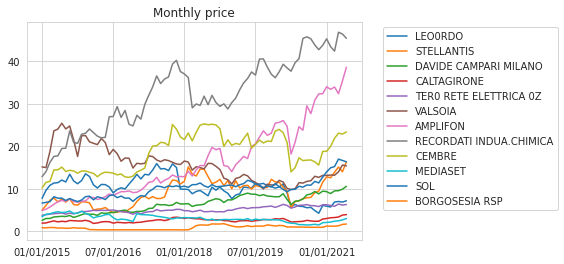

In [11]:
sample_m=pd.DataFrame()
sample_d=pd.DataFrame()
for s in sample:
  sample_m[s]=monthly[s]
  sample_d[s]=daily[s]

ax,fig=plt.subplots(1, 1,)

sample_m.index=pd.to_datetime(monthly["TIME"]).dt.strftime('%d/%m/%Y')

plt.xticks(np.arange(0, len(range(80)) + 1, 18))
for mn in sample:
  plt.plot(sample_m.index,sample_m[mn], label=mn)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Monthly price")
plt.show()





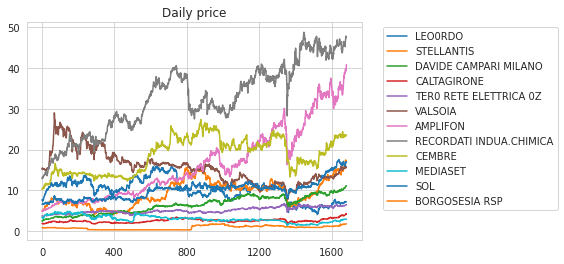

In [12]:
sample_d.index

plt.xticks(np.arange(0, len(range(1680)) + 1, 400))
for mn in sample:
  plt.plot(sample_d.index,sample_d[mn], label=mn)
plt.title("Daily price")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Efficient frontier and optimal portfolio daily

---


Before proceeding we shall identify the vector of return, this can be esteemed with the sample mean. \
Given the verticality of the efficient frontier and the low daily risk free rate, we defined our portfolio in order to obtain an higher return than the one that maximize the Sharpe Ratio. In particular our target for the expected daily return is 0.00085 (0.085%). The same hold for the monthly data, there the target return is set to 0.018 (1.8%).

LEO0RDO                    0.000253
STELLANTIS                 0.001049
DAVIDE CAMPARI MILANO      0.000998
CALTAGIRONE                0.000622
TER0 RETE ELETTRICA 0Z     0.000428
VALSOIA                    0.000200
AMPLIFON                   0.001453
RECORDATI INDUA.CHIMICA    0.000933
CEMBRE                     0.000639
MEDIASET                   0.000183
SOL                        0.000710
BORGOSESIA RSP             0.000886
dtype: float64
Optimal mean variance portfolio weight:  [-0.08130548  0.00775987  0.17384346  0.18606827  0.10717506  0.05430654
  0.1089333   0.10292528  0.14083745 -0.03106928  0.15075055  0.07977497]
Optimal mean variance portfolio Variance:  9.16432653944583e-05
Optimal mean variance portfolio return:  0.00085


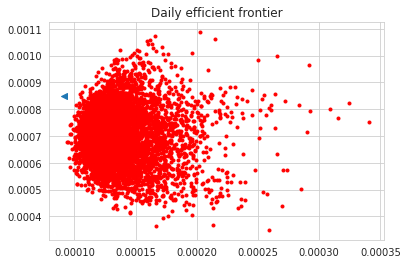

In [14]:
def Return(df):
    ret_df=df.pct_change()
    return ret_df

def Esteem_ret(df):
    E_ret=df.mean()
    return E_ret

def Variance(wi,Sigma):
    s = np.linalg.multi_dot((wi, Sigma, np.transpose(wi)))
    return s.item()

def P_ret(wi,returns):
    r = np.dot(returns, np.transpose(wi))
    return r

def Rgn_weight(df):
    l=len(df)
    wi = np.random.dirichlet(np.ones(l), size=1)
    return wi

def efficient_frontier(returns, Sigma, iteration=1000):
    R=[]
    S=[]
    re=[]
    si=[]
    for i in range(iteration):
        wi=Rgn_weight(returns)
        r=P_ret(wi,returns)
        s=Variance(wi,Sigma)
        R.append(r.item())
        S.append(s)
    plt.scatter(S,R,label="Space of linear combination of assets portfolio",marker='.',c="r")

def minimum_var(target,returns, Sigma):
    l = len(returns)
    a = np.linalg.multi_dot((np.transpose(returns), np.linalg.inv(Sigma), returns))
    b = np.linalg.multi_dot((np.transpose(returns), np.linalg.inv(Sigma), np.ones(len(returns))))
    c = np.linalg.multi_dot((np.transpose(np.ones(len(returns))), np.linalg.inv(Sigma), np.ones(len(returns))))
    det = (np.dot(a, c) - b ** 2)
    w1=np.linalg.multi_dot((np.linalg.inv(Sigma)/det,(np.dot(c,returns)-b)*target))
    w2=np.linalg.multi_dot((np.linalg.inv(Sigma)/det,a-np.dot(b,returns)))
    w=w1+w2
    return w



return_d=Return(sample_d)
return_m=Return(sample_m)
return_vector_d=Esteem_ret(return_d)
return_vector_m=Esteem_ret(return_m)
print(return_vector_d)


efficient_frontier(return_vector_d,Sample_Cov_d,iteration=5000)
plt.title("Daily efficient frontier")

E_r=0.00085
E_w = minimum_var(E_r,return_vector_d,Sample_Cov_d)
print("Optimal mean variance portfolio weight: ", E_w)
E_v=Variance(E_w,Sample_Cov_d)
print("Optimal mean variance portfolio Variance: ", E_v)
print("Optimal mean variance portfolio return: ", E_r)
plt.scatter(E_v,E_r,marker='<')
plt.show()

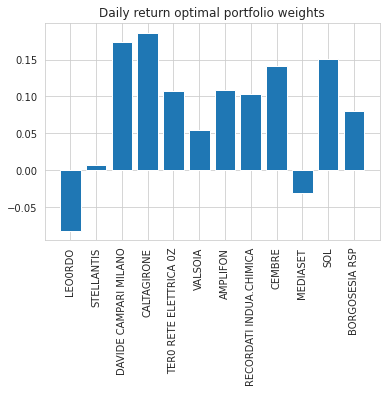

In [29]:
leg=pd.DataFrame()
leg["w"]=E_w
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Daily return optimal portfolio weights")
plt.show()

Choosing as Mean-Variance optimal portfolio the one with target return equal to 0.085%, we can observe that can be obtained by short-selling some of the securities (Leonardo and Mediaset). To obtain the same result we will first plot the efficient frontier assuming absence of short selling, and then we will identify the portfolio with the same return placed on the frontier.
To plot the efficient frontier we will need to solve an optimization problem we will use the sSiPy class *optimize*, in particular, using the sequential least square quadratic programming ('SLSQP') technique.

Weight with no short constraint  [0.04235458 0.1157038  0.11118403 0.07657735 0.05860295 0.03764281
 0.15309456 0.10518849 0.07812405 0.03591135 0.08470848 0.10090755]


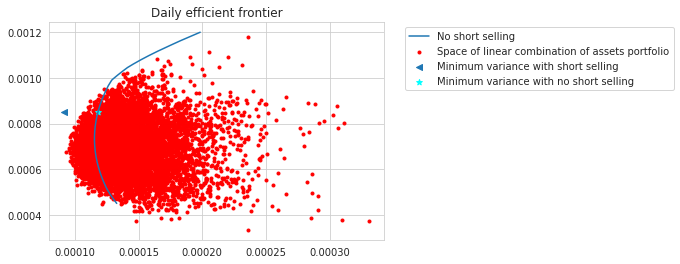

In [31]:
ret_d=return_d
ret_m=return_m
r_d=return_vector_d
r_m=return_vector_m
Cov_d=Sample_Cov_d
Cov_m=Sample_Cov_m

target=np.linspace(0.00045,0.0012,200)


def No_Short_Efficient(target,r,Cov):
    frontier=[]
    for ee in target:
        def objective(w):
            return np.linalg.multi_dot((np.transpose(w), Cov, w))

        def constraint1(w):
            return np.dot(r, np.transpose(w)) - ee

        def constraint2(w):
            sum_i = 1
            for i in range(len(w)):
                sum_i = sum_i - w[i]
            return sum_i
        b = (0.0, 1.0)
        B = (b, b, b, b, b, b, b, b, b, b, b, b)
        con1 = {'type': 'eq', 'fun': constraint1}
        con2 = {'type': 'eq', 'fun': constraint2}
        cons = [con1, con2]
        guess = [1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12]
        sol=spo.minimize(objective,guess, method='SLSQP',bounds=B,constraints=cons)
        frontier.append(sol.x)
        X = []
        Y = []
        for w in frontier:
            Y.append(P_ret(w, r))
            X.append(Variance(w, Cov))
    plt.plot(X,Y,label="No short selling")

def No_Short_GMV(target,r,Cov):
    def objective_2(w):
        return np.linalg.multi_dot((np.transpose(w), Cov, w))
    def constrain1(w):
        return np.dot(r, np.transpose(w)) - target
    def constrain2(w):
        sum_i = 1
        for i in range(len(w)):
            sum_i = sum_i - w[i]
        return sum_i
    b = (0.0, 1.0)
    B = (b, b, b, b, b, b, b, b, b, b, b, b)
    con1 = {'type': 'eq', 'fun': constrain1}
    con2 = {'type': 'eq', 'fun': constrain2}
    cons = [con1, con2]
    guess = [1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12]
    sol2=spo.minimize(objective_2,guess, method='SLSQP',bounds=B,constraints=cons)
    y=P_ret(sol2.x, r)
    x=Variance(sol2.x, Cov)
    plt.scatter(x,y,marker='*',c='cyan',label="Minimum variance with no short selling")
    return sol2

daily=efficient_frontier(r_d,Cov_d,10000)
No_Short_Efficient(target=target,r=r_d,Cov=Cov_d)

plt.title("Daily efficient frontier")

min_ret=E_r
plt.scatter(E_v,E_r,marker='<',label="Minimum variance with short selling")
GMV_NS=No_Short_GMV(min_ret,r_d,Cov_d)
print("Weight with no short constraint ",GMV_NS.x)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

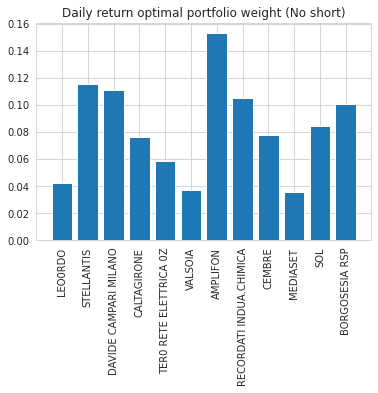

In [32]:
leg=pd.DataFrame()
leg["w"]=GMV_NS.x
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Daily return optimal portfolio weight (No short)")
plt.show()

## Compute historical return of portfolio

In [33]:
p_ret_d=ret_d*GMV_NS.x
p_ret_d["Portfolio Return"]=p_ret_d.sum(axis=1)

print("Daily Portfolio return summary statistics")
stats = p_ret_d["Portfolio Return"].describe()
stats.loc["Variance"] = p_ret_d["Portfolio Return"].var()
stats.loc["Skewness"] = p_ret_d["Portfolio Return"].skew().tolist()
stats.loc["Kurtosis"] = p_ret_d["Portfolio Return"].kurtosis().tolist()
stats

Daily Portfolio return summary statistics


count       1683.000000
mean           0.000849
std            0.010866
min           -0.131205
25%           -0.004013
50%            0.000844
75%            0.006815
max            0.068368
Variance       0.000118
Skewness      -1.315289
Kurtosis      17.043098
Name: Portfolio Return, dtype: float64

We can highlight the fact that the daily return assume a leptocurtic distribution with very fat tail. The range goes from -13% and +6%.


### Plot efficient ferontier with and without short selling

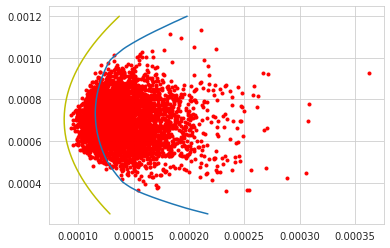

In [34]:
def Short_Efficient(target,r,Cov,guess,lab="Short selling",c="y"):
    frontier=[]
    for ee in target:
        def objective(w):
            return np.linalg.multi_dot((np.transpose(w), Cov, w))

        def constraint1(w):
            return np.dot(r, np.transpose(w)) - ee

        def constraint2(w):
            sum_i = 1
            for i in range(len(w)):
                sum_i = sum_i - w[i]
            return sum_i
        b = (-1, 1)
        B = (b, b, b, b, b, b, b, b, b, b, b, b)
        con1 = {'type': 'eq', 'fun': constraint1}
        con2 = {'type': 'eq', 'fun': constraint2}
        cons = [con1, con2]
        sol=spo.minimize(objective,guess, method='SLSQP',bounds=B,constraints=cons)
        frontier.append(sol.x)
        X = []
        Y = []
        for w in frontier:
            Y.append(P_ret(w, r))
            X.append(Variance(w, Cov))
    plt.plot(X,Y, color=c,label=lab)
  
target=np.linspace(0.00025,0.0012,200)

efficient_frontier(r_d,Cov_d,5000)
Short_Efficient(target,r_d,Cov_d,E_w)
No_Short_Efficient(target,r_d,Cov_d)
plt.show()

## Optimal Portfolio weight, monthly data

Optimal mean variance portfolio weight:  [-0.12267538  0.05630479  0.13791958  0.07645352  0.37965411 -0.07675156
  0.10393083  0.16452908 -0.01821671 -0.03296838  0.26413838  0.06768176]
Optimal mean variance portfolio Variance:  0.0013999029492581855
Optimal mean variance portfolio return:  0.018


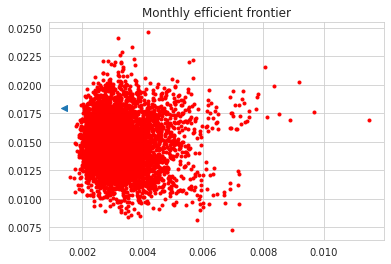

In [35]:
efficient_frontier(return_vector_m,Sample_Cov_m,iteration=5000)
plt.title("Monthly efficient frontier")

E_r_m=0.018
E_w_m = minimum_var(E_r_m,return_vector_m,Sample_Cov_m)
print("Optimal mean variance portfolio weight: ", E_w_m)
E_v_m=Variance(E_w_m,Sample_Cov_m)
print("Optimal mean variance portfolio Variance: ", E_v_m)
print("Optimal mean variance portfolio return: ", E_r_m)
plt.scatter(E_v_m,E_r_m,marker='<')

plt.show()

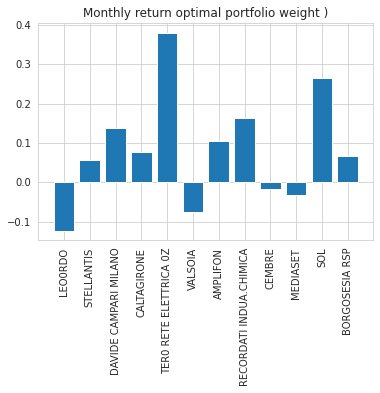

In [36]:
leg=pd.DataFrame()
leg["w"]=E_w_m
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Monthly return optimal portfolio weight )")
plt.show()

Weight with no short constraint  [0.00000000e+00 1.27892991e-02 1.28300002e-01 0.00000000e+00
 1.88769617e-01 7.24840683e-18 1.63858172e-01 1.98176966e-01
 1.17960129e-18 1.91952417e-17 2.32528068e-01 7.55778769e-02]


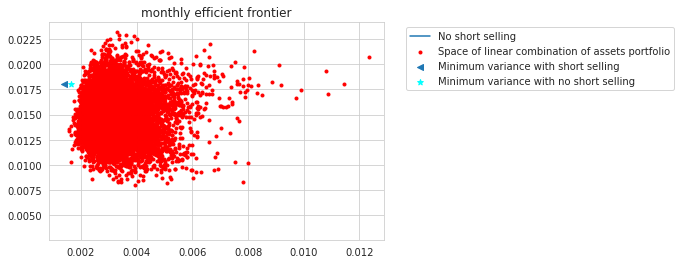

In [37]:
daily=efficient_frontier(r_m,Cov_m,10000)
No_Short_Efficient(target=target,r=r_m,Cov=Cov_m)

plt.title("monthly efficient frontier")

min_ret=E_r_m
plt.scatter(E_v_m,E_r_m,marker='<',label="Minimum variance with short selling")
GMV_NS_m=No_Short_GMV(min_ret,r_m,Cov_m)
print("Weight with no short constraint ",GMV_NS_m.x)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

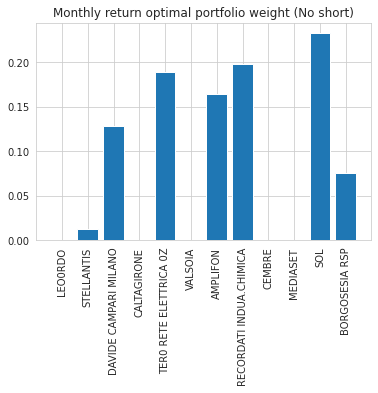

In [39]:
leg=pd.DataFrame()
leg["w"]=GMV_NS_m.x
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Monthly return optimal portfolio weight (No short)")
plt.show()

In [40]:
p_ret_m=ret_m*GMV_NS_m.x
p_ret_m["Portfolio Return"]=p_ret_m.sum(axis=1)

print("Monthly Portfolio return summary statistics")
stats = p_ret_m["Portfolio Return"].describe()
stats.loc["Variance"] = p_ret_m["Portfolio Return"].var()
stats.loc["Skewness"] = p_ret_m["Portfolio Return"].skew().tolist()
stats.loc["Kurtosis"] = p_ret_m["Portfolio Return"].kurtosis().tolist()
stats

Monthly Portfolio return summary statistics


count       78.000000
mean         0.017769
std          0.040154
min         -0.078191
25%         -0.006422
50%          0.015917
75%          0.041436
max          0.095326
Variance     0.001612
Skewness    -0.026208
Kurtosis    -0.279800
Name: Portfolio Return, dtype: float64

Differently from the daily return, we have a much more tight distribution with a range that goes from -7% to +9%. Moreover, we have a larger value for the mean in the monthly data frame, explained by the larger price volatility during the longer time frame. 

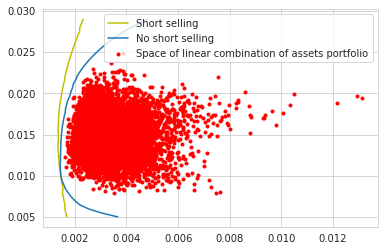

In [41]:
target=np.linspace(0.005,0.029)

efficient_frontier(r_m,Cov_m,10000)
Short_Efficient(target,r_m,Cov_m,E_w_m)
No_Short_Efficient(target,r_m,Cov_m)
plt.legend()
plt.show()

# Market Portfolio and Beta
## Market portfolio return


In [42]:
FTSE_d=pd.read_csv("/mibD.csv",sep=";")
FTSE_m=pd.read_csv("/mibM.csv",sep=";")

MIB_ret_d=FTSE_d["FTSE ITALIA ALL SHARE - PRICE INDEX"].pct_change()
MIB_ret_m=FTSE_m["FTSE ITALIA ALL SHARE - PRICE INDEX"].pct_change()

MIB_ret_d

0            NaN
1       0.006858
2      -0.044704
3      -0.003546
4      -0.001583
          ...   
1678   -0.000448
1679   -0.002575
1680   -0.004242
1681    0.003680
1682    0.002155
Name: FTSE ITALIA ALL SHARE - PRICE INDEX, Length: 1683, dtype: float64

In [43]:
print("Daily FTSE ITALIA ALL SHARE return summary statistics")
stats = MIB_ret_d.describe()
stats.loc["Variance"] = MIB_ret_d.var()
stats.loc["Skewness"] = MIB_ret_d.skew().tolist()
stats.loc["Kurtosis"] = MIB_ret_d.kurtosis().tolist()
mkt_r_d=stats[1]
stats


Daily FTSE ITALIA ALL SHARE return summary statistics


count       1682.000000
mean           0.000424
std            0.014055
min           -0.163977
25%           -0.005486
50%            0.000726
75%            0.007319
max            0.083281
Variance       0.000198
Skewness      -1.542195
Kurtosis      17.807095
Name: FTSE ITALIA ALL SHARE - PRICE INDEX, dtype: float64

We observe similar kurtosis and skewness with the portfolio daily return, but we can highlight the fact that the mean is smaller while the standard deviation is larger.

In [44]:
print("Monthly FTSE ITALIA ALL SHARE return summary statistics")
stats = MIB_ret_m.describe()
stats.loc["Variance"] = MIB_ret_m.var()
stats.loc["Skewness"] = MIB_ret_m.skew().tolist()
stats.loc["Kurtosis"] = MIB_ret_m.kurtosis().tolist()
mkt_r_m=stats[1]
stats

Monthly FTSE ITALIA ALL SHARE return summary statistics


count       77.000000
mean         0.005992
std          0.059700
min         -0.231760
25%         -0.023627
50%          0.010456
75%          0.039875
max          0.197848
Variance     0.003564
Skewness    -0.555264
Kurtosis     3.522926
Name: FTSE ITALIA ALL SHARE - PRICE INDEX, dtype: float64

The monthly distribution of market return has much difference from the portfolio monthly return. First of all, we have larger kurtosis and a range that goes from -23% to +20% (-7% to +9% for optimal portfolio). Then we have a smaller mean, in particular, the FTSE has a mean of order $E^{-3}$ while the optimal portfolio has a mean of order $E^{-2}$. Finally, we can highlight that the degree of symmetry and the volatility are similar between the two distributions.

In [45]:
market_return_d=ret_d

market_return_d["FTSE ITALIA"]=MIB_ret_d.to_list()
market_return_d
Market_Covariance_d=Covariance_matrix(market_return_d)
Cov_im_d=Market_Covariance_d["FTSE ITALIA"][0:12]

print(Cov_im_d)


LEO0RDO                    0.000234
STELLANTIS                 0.000252
DAVIDE CAMPARI MILANO      0.000123
CALTAGIRONE                0.000083
TER0 RETE ELETTRICA 0Z     0.000132
VALSOIA                    0.000094
AMPLIFON                   0.000120
RECORDATI INDUA.CHIMICA    0.000119
CEMBRE                     0.000080
MEDIASET                   0.000194
SOL                        0.000072
BORGOSESIA RSP             0.000021
Name: FTSE ITALIA, dtype: float64


In [48]:
market_return_m=ret_m

market_return_m["FTSE ITALIA"]=MIB_ret_m.to_list()
market_return_m
Market_Covariance_m=Covariance_matrix(market_return_m)
Cov_im_m=Market_Covariance_m["FTSE ITALIA"][0:12]
print("Covariance between market and securities")
print(Cov_im_d)


Covariance between market and securities
LEO0RDO                    0.000234
STELLANTIS                 0.000252
DAVIDE CAMPARI MILANO      0.000123
CALTAGIRONE                0.000083
TER0 RETE ELETTRICA 0Z     0.000132
VALSOIA                    0.000094
AMPLIFON                   0.000120
RECORDATI INDUA.CHIMICA    0.000119
CEMBRE                     0.000080
MEDIASET                   0.000194
SOL                        0.000072
BORGOSESIA RSP             0.000021
Name: FTSE ITALIA, dtype: float64


In [49]:
def Beta(Covar):
  return (Covar/MIB_ret_d.var())

Asset_Beta_d=[]
for i in Cov_im_d:
  Asset_Beta_d.append(Beta(i))
Betas_d=pd.DataFrame()
Betas_d["Asset"]=sample
Betas_d["Beta"]=Asset_Beta_d
print("Asset beta")
Betas_d

Asset beta


,Asset,Beta
0,LEO0RDO,1.183096
1,STELLANTIS,1.274062
2,DAVIDE CAMPARI MILANO,0.624466
3,CALTAGIRONE,0.419110
4,TER0 RETE ELETTRICA 0Z,0.667047
5,VALSOIA,0.475138
6,AMPLIFON,0.606755
7,RECORDATI INDUA.CHIMICA,0.601354
8,CEMBRE,0.406148
9,MEDIASET,0.983774


In [50]:
Portfolio_Beta_d=np.dot(GMV_NS.x,Asset_Beta_d)
print("Portfolio Beta (daily):")
Portfolio_Beta_d

Portfolio Beta (daily):


0.6209331231970061

Assuming that the risk free rate is annual, with composite interest rates, the daily equivalent interest rate can be computed by $r_{d}=(1+r_{y})^{\frac{1}{360}} -1$

1.3664590650108721e-05


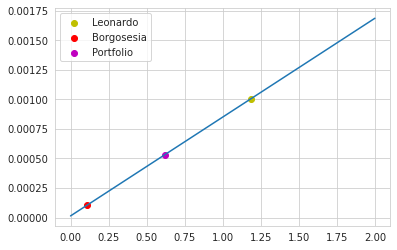

In [51]:
risk_free_yearly=0.005
rf_d=((1+0.005)**(1/365))-1
print(rf_d)
b_d=np.linspace(0,2)
SML_d=rf_d+b_d*(E_r-rf_d)
plt.plot(b_d,SML_d)
Bleo=Betas_d["Beta"][0]
plt.scatter(x=Bleo,y=rf_d+Betas_d["Beta"][0]*(E_r-rf_d),label="Leonardo",c='y')
plt.scatter(x=Betas_d["Beta"][11],y=rf_d+Betas_d["Beta"][11]*(E_r-rf_d),label="Borgosesia",c='r')
plt.scatter(x=Portfolio_Beta_d,y=rf_d+Portfolio_Beta_d*(E_r-rf_d),label="Portfolio",c='m')
plt.legend()
plt.show()

As we can see, the SML is verified for both the securities and the portfolio in the daily term. 
## Monthly data
Consider now the monthly data.

In [53]:
market_return_m=ret_m

market_return_m["FTSE ITALIA"]=MIB_ret_m.to_list()
market_return_m
Market_Covariance_m=Covariance_matrix(market_return_m)
Cov_im_m=Market_Covariance_m["FTSE ITALIA"][0:12]
print("Covariance between market return and securities (Monthly)")
print(Cov_im_m)

Covariance between market return and securities (Monthly)
LEO0RDO                    0.005356
STELLANTIS                 0.005625
DAVIDE CAMPARI MILANO      0.001973
CALTAGIRONE                0.003017
TER0 RETE ELETTRICA 0Z     0.001427
VALSOIA                    0.002002
AMPLIFON                   0.002014
RECORDATI INDUA.CHIMICA    0.001352
CEMBRE                     0.003577
MEDIASET                   0.004376
SOL                        0.001026
BORGOSESIA RSP             0.000302
Name: FTSE ITALIA, dtype: float64


In [54]:
def Beta(Covar):
  return (Covar/MIB_ret_m.var())

Asset_Beta_m=[]
for i in Cov_im_m:
  Asset_Beta_m.append(Beta(i))
Betas_m=pd.DataFrame()
Betas_m["Asset"]=sample
Betas_m["Beta"]=Asset_Beta_m
print("Asset beta")
Betas_m

Asset beta


,Asset,Beta
0,LEO0RDO,1.502819
1,STELLANTIS,1.578169
2,DAVIDE CAMPARI MILANO,0.553562
3,CALTAGIRONE,0.846436
4,TER0 RETE ELETTRICA 0Z,0.400298
5,VALSOIA,0.561631
6,AMPLIFON,0.564981
7,RECORDATI INDUA.CHIMICA,0.379242
8,CEMBRE,1.003650
9,MEDIASET,1.227766


In [55]:
Portfolio_Beta_m=np.dot(GMV_NS.x,Asset_Beta_m)
print("Portfolio Beta (monthly):")
Portfolio_Beta_m

Portfolio Beta (monthly):


0.6990371622152824


the risk free rate can be converted in monthly using the following formula $r_{d}=(1+r_{y})^{\frac{1}{12}} -1$

0.00041571484472902043


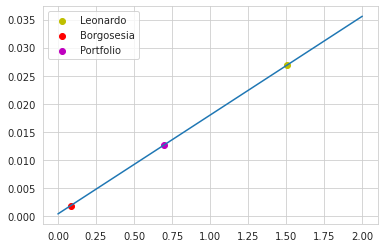

In [56]:
rf_m=(1+risk_free_yearly)**(1/12) -1
print(rf_m)
b_m=np.linspace(0,2)
SML_m=rf_m+b_m*(E_r_m-rf_m)
plt.plot(b_m,SML_m)
Bleo=Betas_m["Beta"][0]
plt.scatter(x=Bleo,y=rf_m+Betas_m["Beta"][0]*(E_r_m-rf_m),label="Leonardo",c='y')
plt.scatter(x=Betas_m["Beta"][11],y=rf_m+Betas_m["Beta"][11]*(E_r_m-rf_m),label="Borgosesia",c='r')
plt.scatter(x=Portfolio_Beta_m,y=rf_m+Portfolio_Beta_m*(E_r_m-rf_m),label="Portfolio",c='m')
plt.legend()
plt.show()

Once again, the SML is verified, with some small error.

# Black Litterman
First of all, we define a function to identify the posterior distribution for the return vector and variance-covariance matrix. We assume a risk aversion coefficient equal to 1.5 for both the daily and monthly time frame.\
Our views are focused on:
-  Cembre and Leonardo, in particular, we expect that Cembre overperforms Leonardo's return by 0.01%; we such view since we expect a younger company to exploit its' growth opportunity.
- We expect Campari to overperform Amplifon by 0.05% since we assume a negative correlation for the two sectors.
- we expect a return of 0.04% (instead of 0.02%) from Valsoia, due to the high growth rate of the healthy food sector.
- we expect a return of -0.1%  (instead of +0.018%) from Mediaset since the company is not approaching competitively the streaming business.


All the views are built on our perception, and shall not be considered as a professional view, since we lack real experience in the financial market.
In order to identify the risk aversion coefficient, we built a function that measures the market-implied risk aversion coefficient. This function consider the risk free rate, the market variance and the market return $\delta = \frac{R-R_f}{\sigma^2}$. With the market, we refer to the set of assets we have initially identified as suitable for investment.



### Market equilibrium weight
Based on the market capitalization of the chosen securities, we built a weight vector that defines each weight as the contribution to the total market capitalization. We will not use these weights in the computation of the black letterman model, however, we decided to build the function if necessary for future application.


In [57]:
def risk_coeff(rf,ret,sig):
    delta=[]
    for i in range(len(ret)):
        d=(ret[i]-rf)/np.diag(sig)[i]
        delta.append(d)
    ri_av=np.mean(delta)
    return ri_av
risk_aver=risk_coeff(rf_d,r_d,Cov_d)

In [58]:
capitalization=pd.read_table("/cap.csv",sep=";")
Mkt_eq_w=[i/capitalization["MktCap"].sum() for i in capitalization["MktCap"]]
mkt_r_eq_d=P_ret(Mkt_eq_w,r_d)
mkt_r_eq_m=P_ret(Mkt_eq_w,r_m)
mkt_r_d

0.0004235090326430884

In [59]:


def Sharpe_ratio(Return,Volatility,risk_free):
    SR=(Return-risk_free)/Volatility
    return SR

def GMVP(returns,Sigma):
    l = len(returns)
    wi=np.dot(np.linalg.inv(Sigma),np.ones(l))/(np.linalg.multi_dot((np.ones(l),np.linalg.inv(Sigma),np.transpose(np.ones(l)))))
    r = np.dot(returns, np.transpose(wi))
    s = np.linalg.multi_dot((wi, Sigma, np.transpose(wi)))
    return [s.item(),wi,r.item()]

def Black_Litterman_Opt(ret,sig,P,tau,Q,E_r,mkt_r):
    V=np.dot(P,np.transpose(ret))
    #print(V)
    w_mkt=minimum_var(mkt_r,ret,sig) #target is daily return on market portfolio
    Omega1=omega(P,sig,tau)
    risk_avr=1
    EQ_ret=risk_avr*np.dot(sig,np.transpose(w_mkt))
    tauv = tau*np.linalg.inv(sig)
    BL_Var=sig+(np.linalg.inv(tauv+np.linalg.multi_dot((np.transpose(P),np.linalg.inv(Omega1),P))))
    comp1= np.linalg.inv(np.linalg.inv(tau*BL_Var)+np.linalg.multi_dot((np.transpose(P),np.linalg.inv(Omega1),P)))
    comp21=np.dot(np.linalg.inv(tau*BL_Var),EQ_ret)
    comp22=+np.linalg.multi_dot((np.transpose(P),np.linalg.inv(Omega1),np.transpose(Q)))
    comp2=np.transpose(comp21+comp22)
    BL_E_r=np.dot(comp1,comp2)
    BL_r=[]
    for i in BL_E_r:
        BL_r.append(i.item())
    BL_w=minimum_var(E_r,BL_r,BL_Var)
    P_Var=Variance(BL_w,BL_Var)
    print("Black-Litterman optimal weight: ", BL_w)
    print(sum(BL_w))
    print("-------------------------------------------")
    print("Volatility: ", np.sqrt(P_Var))
    dta=[BL_E_r,BL_Var]
    print(dta)
    SR=Sharpe_ratio(P_ret(BL_w,BL_r),np.sqrt(P_Var),rf_d)
    print("Sharpe ratio: ", SR)
    return BL_w

P=np.matrix([np.array((-1,0,0,0,0,0,0,0,1,0,0,0)),
             np.array((0,0,1,0,0,0,-1,0,0,0,0,0)),
             np.array((0,0,0,0,0,1,0,0,0,0,0,0)),
             np.array((0,0,0,0,0,0,0,0,0,-1,0,0)),
                          ])
Q=np.array((0.001,0.005,0.004,-0.001))     
#means: Cembre will overperfom wrt to leonardo by 0.1%, campari will overperfom amplifon by 0.05%; valsoia will overperform by 0.2% and mediaset will underperform by 0.15%

def omega(P,sig,tau):
    diag=[]
    for k in range(len(P)):
        pk=P[k]
        omk=np.linalg.multi_dot((pk,sig,np.transpose(pk)))
        diag.append(omk.item())
    l=len(diag)
    Omega = np.zeros((l, l))
    np.fill_diagonal(a=Omega, val=np.array(diag))
    Omega=Omega*tau
    return Omega

tau=0.05
#tau=1/1683
Black_Litterman_Opt(r_d,Cov_d,P,tau,Q,0.0007,mkt_r_eq_d)
plt.show()

def Black_Litterman_w(ret,sig,P,tau,Q,E_r,mkt_r):
    V=np.dot(P,np.transpose(ret))
    w_mkt=minimum_var(mkt_r,ret,sig) #target is daily return on market portfolio
    Omega1=omega(P,sig,tau)
    risk_avr=1
    EQ_ret=risk_avr*np.dot(sig,np.transpose(w_mkt))
    tauv = tau*np.linalg.inv(sig)
    BL_Var=sig+(np.linalg.inv(tauv+np.linalg.multi_dot((np.transpose(P),np.linalg.inv(Omega1),P))))
    comp1= np.linalg.inv(np.linalg.inv(tau*BL_Var)+np.linalg.multi_dot((np.transpose(P),np.linalg.inv(Omega1),P)))
    comp21=np.dot(np.linalg.inv(tau*BL_Var),EQ_ret)
    comp22=+np.linalg.multi_dot((np.transpose(P),np.linalg.inv(Omega1),np.transpose(Q)))
    comp2=np.transpose(comp21+comp22)
    BL_E_r=np.dot(comp1,comp2)
    BL_r=[]
    for i in BL_E_r:
        BL_r.append(i.item())
    BL_w=minimum_var(E_r,BL_r,BL_Var)
    return [BL_w,BL_r,BL_Var]
BL_ww=Black_Litterman_w(r_d,Cov_d,P,tau,Q,0.0007,mkt_r_eq_d)[0]
BL_rr=Black_Litterman_w(r_d,Cov_d,P,tau,Q,0.0007,mkt_r_eq_d)[1]
BL_vv=Black_Litterman_w(r_d,Cov_d,P,tau,Q,0.0007,mkt_r_eq_d)[2]

Black-Litterman optimal weight:  [-0.08173718 -0.00521767 -0.25106231  0.03052297  0.03273159  0.47396622
  0.27500406  0.01342429  0.10014264  0.37624771  0.02399735  0.01198032]
1.0
-------------------------------------------
Volatility:  0.016625535625083163
[matrix([[ 0.00030163],
        [ 0.00049153],
        [ 0.00131091],
        [ 0.00035912],
        [ 0.00050612],
        [ 0.00208236],
        [-0.00123632],
        [ 0.0002452 ],
        [ 0.00059948],
        [ 0.00081944],
        [ 0.00033736],
        [ 0.00017532]]),                           LEO0RDO  STELLANTIS  ...       SOL  BORGOSESIA RSP
LEO0RDO                  0.004506    0.002529  ...  0.000762        0.000424
STELLANTIS               0.002529    0.010188  ...  0.000889        0.000256
DAVIDE CAMPARI MILANO    0.001375    0.001652  ...  0.000634        0.000238
CALTAGIRONE              0.001014    0.001229  ...  0.000417        0.000363
TER0 RETE ELETTRICA 0Z   0.001098    0.001203  ...  0.000585        0.0002

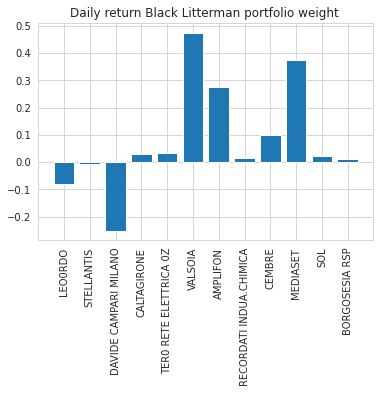

In [62]:
leg=pd.DataFrame()
leg["w"]=BL_ww
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Daily return Black Litterman portfolio weight ")
plt.show()

In [63]:
print("Black litterman portfolio return(historical data): ", P_ret(BL_ww,r_d))

Black litterman portfolio return(historical data):  0.00042382193648748197


Daily Portfolio return summary statistics


count       1683.000000
mean           0.000424
std            0.015305
min           -0.098873
25%           -0.007010
50%            0.000000
75%            0.007439
max            0.110900
Variance       0.000234
Skewness       0.241136
Kurtosis       6.801228
Name: Portfolio Return, dtype: float64

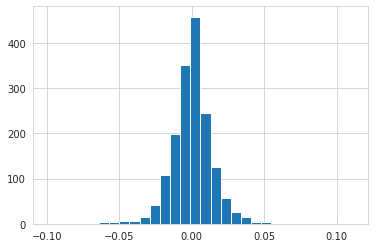

In [64]:

BL_p_ret_d=Return(sample_d)*BL_ww
BL_p_ret_d["Portfolio Return"]=BL_p_ret_d.sum(axis=1)

print("Daily Portfolio return summary statistics")
stats = BL_p_ret_d["Portfolio Return"].describe()
stats.loc["Variance"] = BL_p_ret_d["Portfolio Return"].var()
stats.loc["Skewness"] = BL_p_ret_d["Portfolio Return"].skew().tolist()
stats.loc["Kurtosis"] = BL_p_ret_d["Portfolio Return"].kurtosis().tolist()
BL_p_ret_d["Portfolio Return"].hist(bins=30)
stats

Comparing these results with the optimal daily portfolio summary statistics we can highlight the large difference with the mean of Black-Litterman. In fact, the mean-variance expected return is almost double the size of the Black-Litterman case. Moreover, the variance is 5% larger than the mean-variance case. This difference is explained by the fact that the Black-Litterman model is built starting from the historical data, and hence the portfolio return computed on the Black Litterman weight will give as output unbalanced return and volatility. If we consider the new variance-covariance matrix and return vector, we obtain a new efficient frontier where is placed the BL portfolio.

## Monthly data
Here we change the view, defining them in monthly term instead of daily term. In particular:
-  We expect Cembre to underperform Leonardo by 0.5% 
- We expect Campari to overperform Amplifon by 1%
- We expect a return of 0.5% (instead of 0.3%) from Valsoia.
- we expect a return of -0.1%  (instead of +0.4%) from Mediaset.

In [65]:
risk_aver=risk_coeff(rf_m,r_m,Cov_m)
#tau=1/81
tau=0.05
P=np.matrix([np.array((1,0,0,0,0,0,0,0,-1,0,0,0)),
             np.array((0,0,1,0,0,0,-1,0,0,0,0,0)),
             np.array((0,0,0,0,0,1,0,0,0,0,0,0)),
             np.array((0,0,0,0,0,0,0,0,0,-1,0,0)),
                          ])
Q=np.array((-0.005,0.01,0.005,-0.015))   

Black_Litterman_Opt(r_m,Cov_m,P,tau,Q,0.016,mkt_r_eq_m)
plt.show()
BL_ww_m=Black_Litterman_w(r_m,Cov_m,P,tau,Q,0.016,mkt_r_eq_m)[0]
BL_rr_m=Black_Litterman_w(r_m,Cov_m,P,tau,Q,0.016,mkt_r_eq_m)[1]
BL_vv_m=Black_Litterman_w(r_m,Cov_m,P,tau,Q,0.016,mkt_r_eq_m)[2]

Black-Litterman optimal weight:  [-6.37756303e-01  3.20643953e-03  1.53348981e+00 -3.26394676e-03
 -1.41540693e-02  3.24845988e-01 -1.51975413e+00  6.10087828e-03
  6.33399281e-01  6.71318491e-01  1.15953888e-03  1.40802453e-03]
1.0000000000000004
-------------------------------------------
Volatility:  0.16185532475477496
[matrix([[ 0.00166278],
        [ 0.00273508],
        [ 0.00391035],
        [ 0.00213669],
        [ 0.00210417],
        [ 0.00345452],
        [-0.00127111],
        [ 0.00199511],
        [ 0.00333423],
        [ 0.00879915],
        [ 0.00323876],
        [ 0.00222366]]),                           LEO0RDO  STELLANTIS  ...       SOL  BORGOSESIA RSP
LEO0RDO                  0.122855    0.084311  ...  0.010774        0.001257
STELLANTIS               0.084311    0.260520  ... -0.002310       -0.052207
DAVIDE CAMPARI MILANO    0.046300    0.033762  ...  0.002394       -0.037859
CALTAGIRONE              0.057917    0.063192  ...  0.014808        0.005986
TER0 RETE E

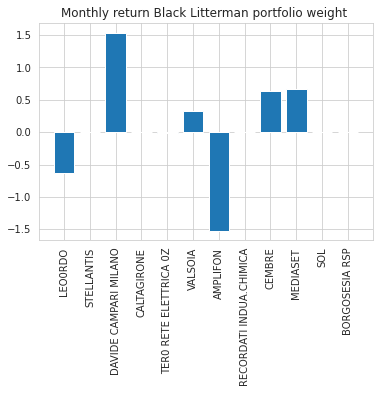

In [67]:
leg=pd.DataFrame()
leg["w"]=BL_ww_m
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Monthly return Black Litterman portfolio weight ")
plt.show()

In [68]:
print("Black litterman portfolio return (historical data): ", P_ret(BL_ww_m,r_m))

Black litterman portfolio return (historical data):  -0.004602720351440855


Monthly Portfolio return summary statistics


count       78.000000
mean        -0.004544
std          0.156928
min         -0.493701
25%         -0.085874
50%         -0.028830
75%          0.078045
max          0.610741
Variance     0.024627
Skewness     0.462282
Kurtosis     2.850049
Name: Portfolio Return, dtype: float64

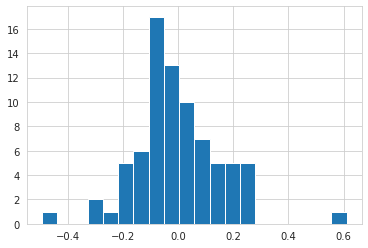

In [70]:

BL_p_ret_m=Return(sample_m)*BL_ww_m
BL_p_ret_m["Portfolio Return"]=BL_p_ret_m.sum(axis=1)

print("Monthly Portfolio return summary statistics")
stats = BL_p_ret_m["Portfolio Return"].describe()
stats.loc["Variance"] = BL_p_ret_m["Portfolio Return"].var()
stats.loc["Skewness"] = BL_p_ret_m["Portfolio Return"].skew().tolist()
stats.loc["Kurtosis"] = BL_p_ret_m["Portfolio Return"].kurtosis().tolist()
BL_p_ret_m["Portfolio Return"].hist(bins=20)
stats

As in the daily case, we obtain similar differences explained by the same facts. We have greater variance and a negative expected return. Moreover, also the fact we have chosen irrealistic views, due to lack of experience in the financial market, could explain the negative expected return.

# Bayesian asset allocation
First, we compute the mean and the variance of the conjugate prior. We consider the mean vector as the original mean vector plus one time each element's standard deviation. For the Variance Covariance matrix, we perturbed it by multiplying each element by two.

## Daily data

In [71]:
By_ret_d=[]
for i in range(12):
  By=r_d[i]+np.sqrt(np.diag(Cov_d)[i])
  By_ret_d.append(By.item())
By_r=pd.DataFrame(By_ret_d)
By_r.index=sample
print("Conjugate prior, vector return: ",By_r )
print("-----------------------------------------------")
print("Variance covariance matrix")
By_cov_d=Cov_d*2
By_cov_d

Conjugate prior, vector return:                                  0
LEO0RDO                  0.024392
STELLANTIS               0.026177
DAVIDE CAMPARI MILANO    0.016966
CALTAGIRONE              0.017471
TER0 RETE ELETTRICA 0Z   0.014362
VALSOIA                  0.018930
AMPLIFON                 0.020956
RECORDATI INDUA.CHIMICA  0.018397
CEMBRE                   0.017591
MEDIASET                 0.024082
SOL                      0.018444
BORGOSESIA RSP           0.031175
-----------------------------------------------
Variance covariance matrix


,LEO0RDO,STELLANTIS,DAVIDE CAMPARI MILANO,CALTAGIRONE,TER0 RETE ELETTRICA 0Z,VALSOIA,AMPLIFON,RECORDATI INDUA.CHIMICA,CEMBRE,MEDIASET,SOL,BORGOSESIA RSP
LEO0RDO,0.001165,0.000636,0.000310,0.000220,0.000279,0.000216,0.000284,0.000270,0.000190,0.000453,0.000163,0.000065
STELLANTIS,0.000636,0.001263,0.000284,0.000217,0.000254,0.000216,0.000305,0.000279,0.000215,0.000497,0.000178,0.000056
DAVIDE CAMPARI MILANO,0.000310,0.000284,0.000510,0.000094,0.000236,0.000138,0.000235,0.000228,0.000123,0.000242,0.000093,0.000039
CALTAGIRONE,0.000220,0.000217,0.000094,0.000568,0.000103,0.000124,0.000107,0.000092,0.000105,0.000161,0.000079,0.000046
TER0 RETE ELETTRICA 0Z,0.000279,0.000254,0.000236,0.000103,0.000388,0.000126,0.000198,0.000219,0.000110,0.000254,0.000103,0.000039
VALSOIA,0.000216,0.000216,0.000138,0.000124,0.000126,0.000702,0.000135,0.000122,0.000130,0.000208,0.000140,0.000023
AMPLIFON,0.000284,0.000305,0.000235,0.000107,0.000198,0.000135,0.000761,0.000275,0.000153,0.000196,0.000139,0.000035
RECORDATI INDUA.CHIMICA,0.000270,0.000279,0.000228,0.000092,0.000219,0.000122,0.000275,0.000610,0.000116,0.000252,0.000115,0.000032
CEMBRE,0.000190,0.000215,0.000123,0.000105,0.000110,0.000130,0.000153,0.000116,0.000575,0.000165,0.000107,0.000054
MEDIASET,0.000453,0.000497,0.000242,0.000161,0.000254,0.000208,0.000196,0.000252,0.000165,0.001142,0.000167,0.000076


Once we have defined the hyperparameters of the prior distribution, we can compute the posterior parameters  by considering the mean and the variance of a distribution defined as the product of two Normal multivariate random variables, hence we have:

In [72]:
def model_covariance(sig,by_sig,leng):
  md_Cov_=np.linalg.inv(leng*np.linalg.inv(sig)+np.linalg.inv(by_sig))
  return md_Cov_

def model_ret(ret,ret_by,sig,by_sig,leng):
  comp1=model_covariance(sig,by_sig,leng)
  comp2=(leng*np.dot(np.linalg.inv(sig),np.transpose(ret))+np.dot(np.linalg.inv(by_sig),np.transpose(ret_by)))
  return np.dot(comp1,comp2)

Sigma_By= model_covariance(Cov_d,By_cov_d,1683)
SI_b=pd.DataFrame(Sigma_By)
SI_b.columns=sample
SI_b.index=sample
print("Posterior Variance-Covariance matrix")
SI_b



Posterior Variance-Covariance matrix


,LEO0RDO,STELLANTIS,DAVIDE CAMPARI MILANO,CALTAGIRONE,TER0 RETE ELETTRICA 0Z,VALSOIA,AMPLIFON,RECORDATI INDUA.CHIMICA,CEMBRE,MEDIASET,SOL,BORGOSESIA RSP
LEO0RDO,3.461166e-07,1.888307e-07,9.211229e-08,6.545278e-08,8.287586e-08,6.418353e-08,8.442724e-08,8.004187e-08,5.648233e-08,1.344242e-07,4.842749e-08,1.936858e-08
STELLANTIS,1.888307e-07,3.750760e-07,8.448496e-08,6.440396e-08,7.544784e-08,6.419577e-08,9.070707e-08,8.283599e-08,6.398447e-08,1.475068e-07,5.292527e-08,1.650288e-08
DAVIDE CAMPARI MILANO,9.211229e-08,8.448496e-08,1.514533e-07,2.797909e-08,7.022162e-08,4.101942e-08,6.974797e-08,6.760737e-08,3.662914e-08,7.174351e-08,2.774757e-08,1.147425e-08
CALTAGIRONE,6.545278e-08,6.440396e-08,2.797909e-08,1.686212e-07,3.054790e-08,3.675937e-08,3.172323e-08,2.723799e-08,3.103906e-08,4.780189e-08,2.334748e-08,1.352176e-08
TER0 RETE ELETTRICA 0Z,8.287586e-08,7.544784e-08,7.022162e-08,3.054790e-08,1.153273e-07,3.747326e-08,5.891958e-08,6.505397e-08,3.254493e-08,7.535456e-08,3.046780e-08,1.161830e-08
VALSOIA,6.418353e-08,6.419577e-08,4.101942e-08,3.675937e-08,3.747326e-08,2.083682e-07,4.004538e-08,3.636788e-08,3.858317e-08,6.184762e-08,4.157201e-08,6.844955e-09
AMPLIFON,8.442724e-08,9.070707e-08,6.974797e-08,3.172323e-08,5.891958e-08,4.004538e-08,2.259351e-07,8.174792e-08,4.554024e-08,5.826815e-08,4.120857e-08,1.049476e-08
RECORDATI INDUA.CHIMICA,8.004187e-08,8.283599e-08,6.760737e-08,2.723799e-08,6.505397e-08,3.636788e-08,8.174792e-08,1.811638e-07,3.444088e-08,7.489612e-08,3.424417e-08,9.488633e-09
CEMBRE,5.648233e-08,6.398447e-08,3.662914e-08,3.103906e-08,3.254493e-08,3.858317e-08,4.554024e-08,3.444088e-08,1.706968e-07,4.908224e-08,3.175631e-08,1.615824e-08
MEDIASET,1.344242e-07,1.475068e-07,7.174351e-08,4.780189e-08,7.535456e-08,6.184762e-08,5.826815e-08,7.489612e-08,4.908224e-08,3.392716e-07,4.950036e-08,2.257444e-08


In [73]:
Return_by=model_ret(r_d,By_ret_d,Cov_d,By_cov_d,1683)
Byes_ret_d=pd.DataFrame(Return_by)
Byes_ret_d.index=sample
Byes_ret_d.columns=[("Return")]
Byes_ret_d

,Return
LEO0RDO,0.000260
STELLANTIS,0.001056
DAVIDE CAMPARI MILANO,0.001003
CALTAGIRONE,0.000627
TER0 RETE ELETTRICA 0Z,0.000432
VALSOIA,0.000206
AMPLIFON,0.001459
RECORDATI INDUA.CHIMICA,0.000938
CEMBRE,0.000644
MEDIASET,0.000190


We can now proceed with the asset allocation.

In [74]:
targ=0.0007

weight_d=minimum_var(targ,Return_by,Sigma_By)
print("Weight: ",weight_d)
print("Bayesian Portfolio return: ", P_ret(weight_d,Return_by) )
print("Bayesian Portfolio variance ", Variance(weight_d,Sigma_By))


Weight:  [-0.04401919 -0.02666497  0.11498862  0.18392358  0.18607869  0.09466759
  0.04576476  0.08343499  0.14859156 -0.00492695  0.14514244  0.07301888]
Bayesian Portfolio return:  0.0006999999999999997
Bayesian Portfolio variance  5.1412513789413795e-08


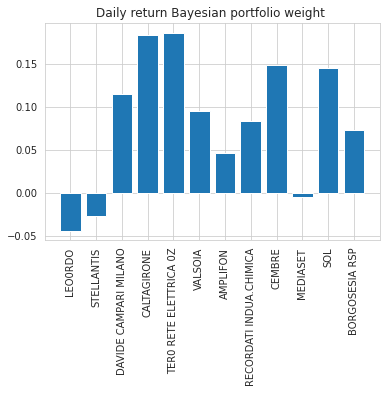

In [75]:
leg=pd.DataFrame()
leg["w"]=weight_d
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Daily return Bayesian portfolio weight ")
plt.show()

Now we proceed computing the summary statistics of the portfolio, considering the historical data.

In [76]:
By_ret_d=pd.DataFrame()
By_ret_d["Bayesian Portfolio return"]=(ret_d.iloc[:,:12]*weight_d).sum(axis=1)
By_ret_d

,Bayesian Portfolio return
0,0.000000
1,-0.003576
2,-0.002794
3,0.003071
4,0.004280
...,...
1678,0.004687
1679,0.006780
1680,0.004140
1681,0.000449


Daily  Bayesian Portfolio return summary statistics


,Bayesian Portfolio return
count,1683.000000
mean,0.000695
std,0.009301
min,-0.099239
25%,-0.004014
50%,0.000414
75%,0.005706
max,0.051398
Variance,0.000087
Skewness,-0.807006


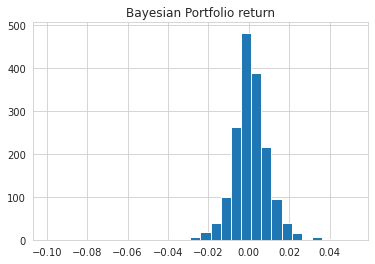

In [77]:
print("Daily  Bayesian Portfolio return summary statistics")
stats = By_ret_d.describe()
stats.loc["Variance"] = By_ret_d.var()
stats.loc["Skewness"] = By_ret_d.skew().tolist()
stats.loc["Kurtosis"] = By_ret_d.kurtosis().tolist()
By_ret_d.hist(bins=30)
stats

 Similarly, with the daily return on the optimal portfolio, we have the same order expected return and volatility. This can be explained by the small difference between the conjugate prior and the daily return distribution.

## Monthly data

In [78]:
By_ret_m=[]
for i in range(12):
  By=r_m[i]+np.sqrt(np.diag(Cov_m)[i])
  By_ret_m.append(By.item())
By_r_m=pd.DataFrame(By_ret_m)
By_r_m.index=sample
print("Conjugate prior, vector return: ",By_r_m )
print("-----------------------------------------------")
print("Variance covariance matrix")
By_cov_m=Cov_m*2
By_cov_m

Conjugate prior, vector return:                                  0
LEO0RDO                  0.123521
STELLANTIS               0.149691
DAVIDE CAMPARI MILANO    0.087680
CALTAGIRONE              0.087091
TER0 RETE ELETTRICA 0Z   0.053368
VALSOIA                  0.087739
AMPLIFON                 0.110606
RECORDATI INDUA.CHIMICA  0.087949
CEMBRE                   0.099444
MEDIASET                 0.133258
SOL                      0.072596
BORGOSESIA RSP           0.216971
-----------------------------------------------
Variance covariance matrix


,LEO0RDO,STELLANTIS,DAVIDE CAMPARI MILANO,CALTAGIRONE,TER0 RETE ELETTRICA 0Z,VALSOIA,AMPLIFON,RECORDATI INDUA.CHIMICA,CEMBRE,MEDIASET,SOL,BORGOSESIA RSP
LEO0RDO,0.027643,0.015517,0.007935,0.010150,0.004150,0.004291,0.006547,0.006006,0.011227,0.012083,0.002277,0.001877
STELLANTIS,0.015517,0.031762,0.004995,0.009771,0.003112,0.005794,0.007101,0.002559,0.010951,0.012029,0.002254,-0.003320
DAVIDE CAMPARI MILANO,0.007935,0.004995,0.008972,0.004013,0.003300,0.004075,0.005481,0.003652,0.005610,0.004002,0.001393,-0.003037
CALTAGIRONE,0.010150,0.009771,0.004013,0.011229,0.001882,0.003660,0.004510,0.002993,0.007038,0.006269,0.002750,0.001468
TER0 RETE ELETTRICA 0Z,0.004150,0.003112,0.003300,0.001882,0.004160,0.002649,0.002957,0.002976,0.002647,0.003662,0.001176,-0.001858
VALSOIA,0.004291,0.005794,0.004075,0.003660,0.002649,0.014169,0.004834,0.003252,0.005863,0.004180,0.003314,0.001251
AMPLIFON,0.006547,0.007101,0.005481,0.004510,0.002957,0.004834,0.012864,0.003193,0.006337,-0.000070,0.000877,-0.003120
RECORDATI INDUA.CHIMICA,0.006006,0.002559,0.003652,0.002993,0.002976,0.003252,0.003193,0.009548,0.002767,0.002944,0.001773,-0.006133
CEMBRE,0.011227,0.010951,0.005610,0.007038,0.002647,0.005863,0.006337,0.002767,0.014440,0.005519,0.003205,0.000875
MEDIASET,0.012083,0.012029,0.004002,0.006269,0.003662,0.004180,-0.000070,0.002944,0.005519,0.032986,0.005778,0.003611


In [79]:
Sigma_By_m= model_covariance(Cov_m,By_cov_m,81)
SI_b_m=pd.DataFrame(Sigma_By_m)
SI_b_m.columns=sample
SI_b_m.index=sample
print("Posterior Variance-Covariance matrix")
SI_b_m


Posterior Variance-Covariance matrix


,LEO0RDO,STELLANTIS,DAVIDE CAMPARI MILANO,CALTAGIRONE,TER0 RETE ELETTRICA 0Z,VALSOIA,AMPLIFON,RECORDATI INDUA.CHIMICA,CEMBRE,MEDIASET,SOL,BORGOSESIA RSP
LEO0RDO,0.000170,0.000095,0.000049,0.000062,0.000025,0.000026,4.016789e-05,0.000037,0.000069,7.412878e-05,0.000014,0.000012
STELLANTIS,0.000095,0.000195,0.000031,0.000060,0.000019,0.000036,4.356324e-05,0.000016,0.000067,7.380012e-05,0.000014,-0.000020
DAVIDE CAMPARI MILANO,0.000049,0.000031,0.000055,0.000025,0.000020,0.000025,3.362553e-05,0.000022,0.000034,2.455041e-05,0.000009,-0.000019
CALTAGIRONE,0.000062,0.000060,0.000025,0.000069,0.000012,0.000022,2.766903e-05,0.000018,0.000043,3.846089e-05,0.000017,0.000009
TER0 RETE ELETTRICA 0Z,0.000025,0.000019,0.000020,0.000012,0.000026,0.000016,1.813992e-05,0.000018,0.000016,2.246672e-05,0.000007,-0.000011
VALSOIA,0.000026,0.000036,0.000025,0.000022,0.000016,0.000087,2.965507e-05,0.000020,0.000036,2.564455e-05,0.000020,0.000008
AMPLIFON,0.000040,0.000044,0.000034,0.000028,0.000018,0.000030,7.892026e-05,0.000020,0.000039,-4.309950e-07,0.000005,-0.000019
RECORDATI INDUA.CHIMICA,0.000037,0.000016,0.000022,0.000018,0.000018,0.000020,1.959178e-05,0.000059,0.000017,1.805834e-05,0.000011,-0.000038
CEMBRE,0.000069,0.000067,0.000034,0.000043,0.000016,0.000036,3.887624e-05,0.000017,0.000089,3.386072e-05,0.000020,0.000005
MEDIASET,0.000074,0.000074,0.000025,0.000038,0.000022,0.000026,-4.309950e-07,0.000018,0.000034,2.023661e-04,0.000035,0.000022


In [80]:
Return_by_m=model_ret(r_m,By_ret_m,Cov_m,By_cov_m,81)
Byes_ret_m=pd.DataFrame(Return_by_m)
Byes_ret_m.index=sample
Byes_ret_m.columns=[("Return")]
Byes_ret_m

,Return
LEO0RDO,0.006679
STELLANTIS,0.024444
DAVIDE CAMPARI MILANO,0.021113
CALTAGIRONE,0.012622
TER0 RETE ELETTRICA 0Z,0.008041
VALSOIA,0.004085
AMPLIFON,0.030898
RECORDATI INDUA.CHIMICA,0.019277
CEMBRE,0.014995
MEDIASET,0.005621


Now we can go over the asset allocation with the posterior parameter.

In [81]:
targ=0.019

weight_m=minimum_var(targ,Return_by_m,Sigma_By_m)
print("Weight: ",weight_m)
print("Bayesian Portfolio return: ", P_ret(weight_m,Return_by_m) )
print("Bayesian Portfolio variance ", Variance(weight_m,Sigma_By_m))


Weight:  [-0.12815623  0.06136497  0.14770974  0.07133002  0.35799457 -0.08442657
  0.1147252   0.17433797 -0.01894157 -0.03180737  0.26557583  0.07029344]
Bayesian Portfolio return:  0.01900000000000001
Bayesian Portfolio variance  1.745374799939696e-05


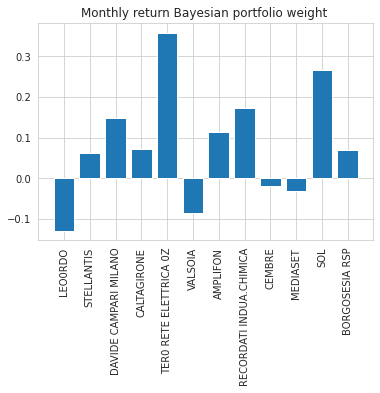

In [82]:
leg=pd.DataFrame()
leg["w"]=weight_m
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Monthly return Bayesian portfolio weight ")
plt.show()

In [83]:
By_ret_m=pd.DataFrame()
By_ret_m["Bayesian Portfolio return (monthly)"]=(ret_m.iloc[:,:12]*weight_m).sum(axis=1)
By_ret_m

,Bayesian Portfolio return (monthly)
TIME,
01/01/2015,0.000000
02/01/2015,0.039599
03/01/2015,0.049578
04/01/2015,0.074548
05/01/2015,-0.015791
...,...
02/01/2021,-0.006282
03/01/2021,-0.020151
04/01/2021,0.080160


Monthly  Bayesian Portfolio return summary statistics


,Bayesian Portfolio return (monthly)
count,78.000000
mean,0.018381
std,0.037529
min,-0.060605
25%,-0.004985
50%,0.013420
75%,0.044287
max,0.098793
Variance,0.001408
Skewness,0.054266


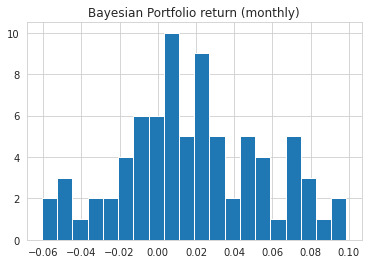

In [85]:
print("Monthly  Bayesian Portfolio return summary statistics")
stats = By_ret_m.describe()
stats.loc["Variance"] = By_ret_m.var()
stats.loc["Skewness"] = By_ret_m.skew().tolist()
stats.loc["Kurtosis"] = By_ret_m.kurtosis().tolist()
By_ret_m.hist(bins=20)
stats

The distribution of monthly mean-variance return and the bayesian portfolio allocation has pretty similar data, the order of each metric is equal, the only difference is the opposite sign in the skewness.

# Global Minimum Variance Portfolio
We porceed now identifying the global minimum variance portfolio.

In [86]:
def GMVP(returns,Sigma):
    l = len(returns)
    wi=np.dot(np.linalg.inv(Sigma),np.ones(l))/(np.linalg.multi_dot((np.ones(l),np.linalg.inv(Sigma),np.transpose(np.ones(l)))))
    r = np.dot(returns, np.transpose(wi))
    s = np.linalg.multi_dot((wi, Sigma, np.transpose(wi)))
    return [s.item(),wi,r.item()]

Global_MV=GMVP(r_d,Cov_d)
print("Weight Global Minimum Variance Portfolio: ", Global_MV[1])
print("Return of Global Minimum Variance Portfolio: ", Global_MV[2])
print("Variance of Global Minimum Variance Portfolio: ", Global_MV[0])

Weight Global Minimum Variance Portfolio:  [-0.03948573 -0.03087393  0.10782199  0.1836694   0.19573889  0.09958535
  0.03805401  0.08105832  0.1495429  -0.00175196  0.14446105  0.07217972]
Return of Global Minimum Variance Portfolio:  0.0006760027449165215
Variance of Global Minimum Variance Portfolio:  8.649207789182885e-05


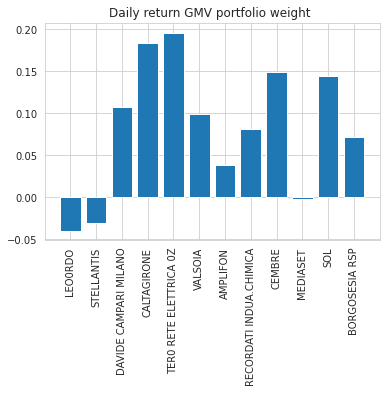

In [87]:
leg=pd.DataFrame()
leg["w"]=Global_MV[1]
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Daily return GMV portfolio weight ")
plt.show()

And the summary statistics for this portfolio.

Daily  GMV Portfolio return summary statistics


,GMV Portfolio return
count,1683.000000
mean,0.000676
std,0.009297
min,-0.098666
25%,-0.004042
50%,0.000361
75%,0.005620
max,0.050956
Variance,0.000086
Skewness,-0.796675


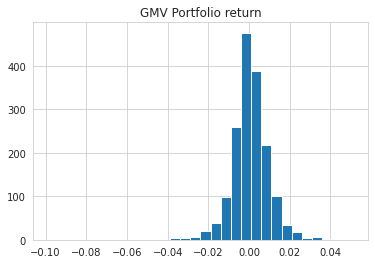

In [88]:
GMVp=pd.DataFrame()
GMVp["GMV Portfolio return"]=(ret_d.iloc[:,:12]*Global_MV[1]).sum(axis=1)
print("Daily  GMV Portfolio return summary statistics")
stats = GMVp.describe()
stats.loc["Variance"] = GMVp.var()
stats.loc["Skewness"] = GMVp.skew().tolist()
stats.loc["Kurtosis"] = GMVp.kurtosis().tolist()
GMVp.hist(bins=30)
stats

## Monthly data

In [89]:
Global_MV_m=GMVP(r_m,Cov_m)
print("Weight Global Minimum Variance Portfolio: ", Global_MV_m[1])
print("Return of Global Minimum Variance Portfolio: ", Global_MV_m[2])
print("Variance of Global Minimum Variance Portfolio: ", Global_MV_m[0])

Weight Global Minimum Variance Portfolio:  [-0.08464071  0.02538464  0.07328826  0.10629881  0.5084918  -0.02334813
  0.03609909  0.10499828 -0.01345175 -0.03668836  0.24998736  0.05358072]
Return of Global Minimum Variance Portfolio:  0.014062879274666483
Variance of Global Minimum Variance Portfolio:  0.0013334462314497544


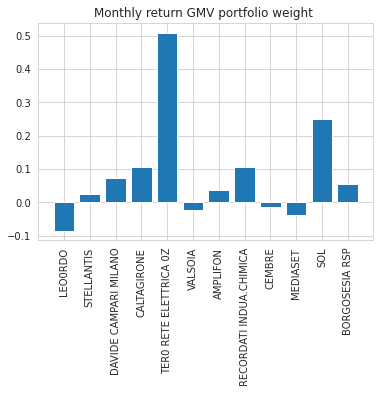

In [90]:
leg=pd.DataFrame()
leg["w"]=Global_MV_m[1]
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Monthly return GMV portfolio weight ")
plt.show()

And as summary statistics we have

Monthly GMV Portfolio return summary statistics


,GMV Portfolio return
count,78.000000
mean,0.013883
std,0.036313
min,-0.074784
25%,-0.011148
50%,0.013452
75%,0.040602
max,0.094631
Variance,0.001319
Skewness,0.017131


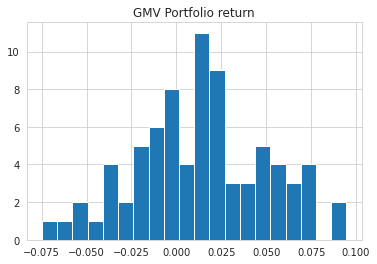

In [92]:
GMVp_m=pd.DataFrame()
GMVp_m["GMV Portfolio return"]=(ret_m.iloc[:,:12]*Global_MV_m[1]).sum(axis=1)
print("Monthly GMV Portfolio return summary statistics")
stats = GMVp_m.describe()
stats.loc["Variance"] = GMVp_m.var()
stats.loc["Skewness"] = GMVp_m.skew().tolist()
stats.loc["Kurtosis"] = GMVp_m.kurtosis().tolist()
GMVp_m.hist(bins=20)
stats

#Linear combination of Portfolios
Now we proceed by comparing each portfolio we built, the expected return, the volatility, and the sharp ratio. The goal is to identify a linear combination of these portfolios in order to obtain another unique portfolio.

In [93]:
Comparison_d=pd.DataFrame()
index=["Weight", "Expected return", "Variance", "Sharpe ratio"]
optimal=[E_w,E_r,E_v,Sharpe_ratio(E_r,np.sqrt(E_v),rf_d)]
optimal_NS=[GMV_NS.x,P_ret(GMV_NS.x,r_d),Variance(GMV_NS.x,Cov_d),Sharpe_ratio(P_ret(GMV_NS.x,r_d),np.sqrt(Variance(GMV_NS.x,Cov_d)),rf_d)]
BL=[BL_ww,P_ret(BL_ww,BL_rr),Variance(BL_ww,BL_vv),Sharpe_ratio(P_ret(BL_ww,BL_rr),np.sqrt(Variance(BL_ww,BL_vv)),rf_d)]
BY=[weight_d,P_ret(weight_d,r_d),Variance(weight_d,Cov_d),Sharpe_ratio(P_ret(weight_d,r_d),np.sqrt(Variance(weight_d,Cov_d)),rf_d)]
GMV=[Global_MV[1],Global_MV[2],Global_MV[0],Sharpe_ratio(Global_MV[2],np.sqrt(Global_MV[0]),rf_d)]

strategy= ["optimal MV", "Optiaml MV (No short)", "Black Litterman", "Bayesian", "Global Minimum Variance"]

Comparison_d["Optimal"]=optimal
Comparison_d["Optimal, no short selling"]=optimal_NS
Comparison_d["Black Litterman"]=BL
Comparison_d["Bayesian"]=BY
Comparison_d["Global Minimum Variance"]=GMV
Comparison_d.index=index
Comparison_d

,Optimal,"Optimal, no short selling",Black Litterman,Bayesian,Global Minimum Variance
Weight,"[-0.08130548046973804, 0.007759870128992652, 0...","[0.042354579753668985, 0.11570379581169382, 0....","[-0.08173718033583983, -0.005217672802034979, ...","[-0.04401918993028142, -0.02666497081401223, 0...","[-0.03948572512822996, -0.030873932233559564, ..."
Expected return,0.00085,0.00085,0.0007,0.00069492,0.000676003
Variance,9.16433e-05,0.00011814,0.000276408,8.6553e-05,8.64921e-05
Sharpe ratio,0.0873635,0.0769454,0.041282,0.0732266,0.0712183


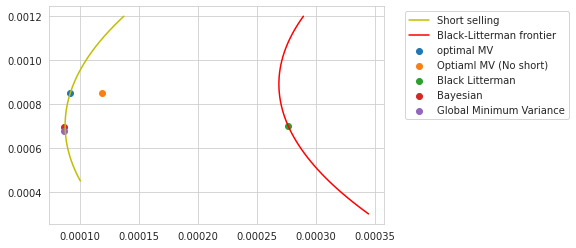

In [94]:
target_d=np.linspace(0.00045,0.0012,200)
Xx=Comparison_d.iloc[2,:]
Yy=Comparison_d.iloc[1]
for i in range(5):
  plt.scatter(Xx[i],Yy[i],label=strategy[i])

Short_Efficient(target_d,r_d,Cov_d,E_w)
Short_Efficient(np.linspace(0.0003,0.0012),BL_rr,BL_vv,BL_ww,"Black-Litterman frontier",c="r")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

And for the monthly data

In [95]:
Comparison_m=pd.DataFrame()
index=["Weight", "Expected return", "Variance", "Sharpe ratio"]
optimal_m=[E_w_m,E_r_m,E_v_m,Sharpe_ratio(E_r_m,np.sqrt(E_v_m),rf_m)]
optimal_NS_m=[GMV_NS_m.x,P_ret(GMV_NS_m.x,r_m),Variance(GMV_NS_m.x,Cov_m),Sharpe_ratio(P_ret(GMV_NS_m.x,r_m),np.sqrt(Variance(GMV_NS_m.x,Cov_m)),rf_m)]
BL_m=[BL_ww_m,P_ret(BL_ww_m,BL_rr_m),Variance(BL_ww_m,BL_vv_m),Sharpe_ratio(P_ret(BL_ww_m,BL_rr),np.sqrt(Variance(BL_ww_m,BL_vv_m)),rf_m)]
BY_m=[weight_m,P_ret(weight_m,r_m),Variance(weight_m,Cov_m),Sharpe_ratio(P_ret(weight_m,r_m),np.sqrt(Variance(weight_m,Cov_m)),rf_m)]
GMV_m=[Global_MV_m[1],Global_MV_m[2],Global_MV_m[0],Sharpe_ratio(Global_MV_m[2],np.sqrt(Global_MV_m[0]),rf_m)]



Comparison_m["Optimal"]=optimal_m
Comparison_m["Optimal, no short selling"]=optimal_NS_m
Comparison_m["Black Litterman"]=BL_m
Comparison_m["Bayesian"]=BY_m
Comparison_m["Global Minimum Variance"]=GMV_m
Comparison_m.index=index
Comparison_m

,Optimal,"Optimal, no short selling",Black Litterman,Bayesian,Global Minimum Variance
Weight,"[-0.1226753848726421, 0.056304790065106844, 0....","[0.0, 0.012789299129570846, 0.1283000018312175...","[-0.637756303411546, 0.003206439534977911, 1.5...","[-0.1281562295146204, 0.06136496815063855, 0.1...","[-0.08464070746554171, 0.025384636569245004, 0..."
Expected return,0.018,0.018,0.016,0.0186195,0.0140629
Variance,0.0013999,0.00162935,0.0261971,0.00142248,0.00133345
Sharpe ratio,0.469976,0.43563,0.0301672,0.482656,0.373727


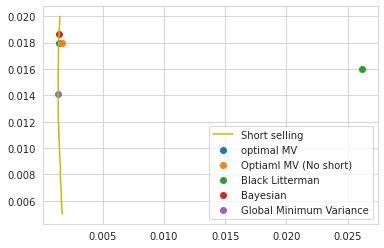

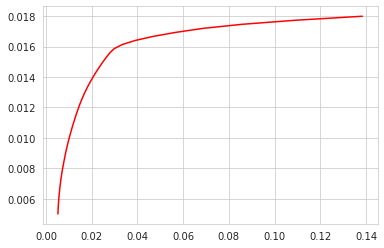

In [98]:

Xx=Comparison_m.iloc[2,:]
Yy=Comparison_m.iloc[1]
for i in range(5):
  plt.scatter(Xx[i],Yy[i],label=strategy[i])
Short_Efficient(np.linspace(0.005,0.02),r_m,Cov_m,E_w_m)
plt.legend()
plt.show()

Short_Efficient(np.linspace(0.005,0.018),BL_rr_m,BL_vv_m,E_w_m,"Black litterman frontier",'r')
plt.show()

The information on the portfolio strategy we arranged in the previous data frames highlights the difference between the five portfolios. Considering the optimal portfolio and the no short optimal portfolio, they share the same return but have a different variance, since in the first portfolio is possible to short some of the assets, while in the second one we have a positivity constraint in the weight's vector. Again, the global minimum variance portfolio is on the efficient frontier and, in particular, is the optimal portfolio with the lowest variance in the linear space of the portfolio. \
Referring to the Bayesian and the Black Litterman optimal portfolio, these strategies are determined through inference on the posterior distribution of historical assets return. More in detail, based on historical return and our perception of future return, we compute a new vector of return and a new variance-covariance matrix, which reflects investors' expectation on assets return. Then the optimal portfolio weights are computed considering the new return vector and variance-covariance matrix. \
So far we explained why the different portfolio has different expected return, volatility and Sharpe ratio, but we must remark that the two frontiers represent two different possible states of the world. The yellow frontier is the frontier defined on the historical data(so is the classical mean-variance optimal frontier), while the red one represents the optimal mean-variance efficient frontier, considering the posterior distribution from the Black Litterman model. \

Given this data, we can compute a linear combination of the portfolio we built so far. Considering that the Optima mean-variance, the Global Minimum variance, and the Bayesian portfolio all lay on the efficient frontier (in both daily and monthly data), we can set larger the linear combination weight to this allocation strategy. If we consider also the Sharpe ratio, we can highlight the benefit of choosing the previously said portfolio. Finally, we can identify the following components from the 5 strategies we identified:
- 35% Optimal portfolio;
- 30% Bayesian optimized portfolio;
- 30% Global minimum variance portfolio;
- 5% Black Litterman optimization portfolio.

In [99]:
Str_w=[0.35,0,0.05,0.30,0.30]
Ww=[optimal[0],optimal_NS[0],BL[0],BY[0],GMV[0]]
F_weight_d=[]
for i in range(5):
  f=Str_w[i]*Ww[i]
  F_weight_d.append(f)
Final_weight_d=sum(F_weight_d)
Final_weight_d

array([-0.05759525, -0.0148066 ,  0.11513528,  0.17692794,  0.15369312,
        0.10098148,  0.07702249,  0.08604306,  0.14374058,  0.00593446,
        0.14084361,  0.07207983])

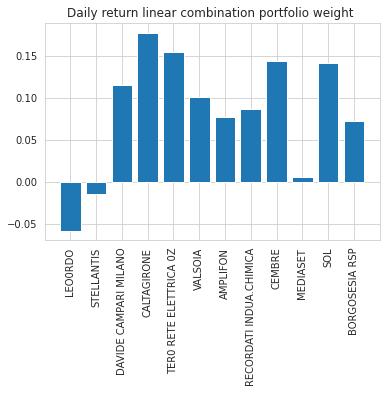

In [101]:
leg=pd.DataFrame()
leg["w"]=Final_weight_d
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Daily return linear combination portfolio weight ")
plt.show()

Daily Linear composition Portfolio return summary statistics


,Linear composition return
count,1683.000000
mean,0.000730
std,0.009342
min,-0.100692
25%,-0.003993
50%,0.000494
75%,0.005662
max,0.054721
Variance,0.000087
Skewness,-0.848264


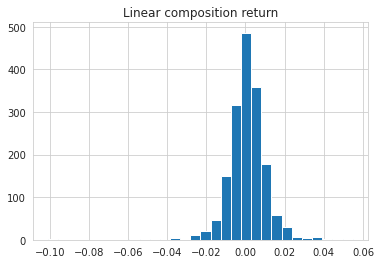

In [102]:
print("Daily Linear composition Portfolio return summary statistics")
Stg_d=pd.DataFrame()
Stg_d["Linear composition return"]=(ret_d.iloc[:,:12]*Final_weight_d).sum(axis=1)
stats = Stg_d.describe()
stats.loc["Variance"] = Stg_d.var()
stats.loc["Skewness"] = Stg_d.skew().tolist()
stats.loc["Kurtosis"] = Stg_d.kurtosis().tolist()
stats.loc["Sharpe Ratio"] =Sharpe_ratio(Stg_d.mean(),Stg_d.std(),rf_d)
Stg_d.hist(bins=30)
stats

In [103]:

Ww=[optimal_m[0],optimal_NS_m[0],BL_m[0],BY_m[0],GMV_m[0]]
F_weight_m=[]
for i in range(5):
  f=Str_w[i]*Ww[i]
  F_weight_m.append(f)
Final_weight_m=sum(F_weight_m)
Final_weight_m

array([-0.13866328,  0.04589188,  0.19124574,  0.07988418,  0.39211715,
       -0.04295316,  0.00563537,  0.1416911 ,  0.01557612,  0.00147827,
        0.24717536,  0.06092126])

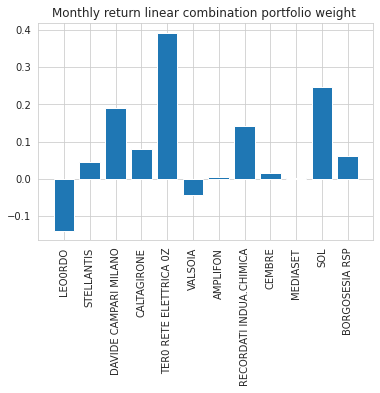

In [105]:
leg=pd.DataFrame()
leg["w"]=Final_weight_m
leg.index=sample
plt.bar(leg.index.values,leg["w"])
plt.xticks(rotation=90)
plt.title("Monthly return linear combination portfolio weight ")
plt.show()

Monthly Linear composition Portfolio return summary statistics


,Linear composition return
count,78.000000
mean,0.015671
std,0.037255
min,-0.068957
25%,-0.010211
50%,0.011558
75%,0.042332
max,0.093186
Variance,0.001388
Skewness,0.086850


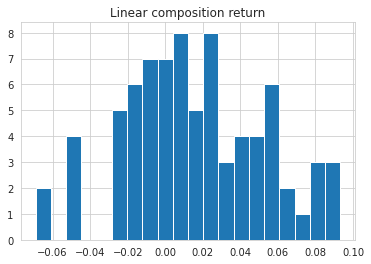

In [107]:
print("Monthly Linear composition Portfolio return summary statistics")
Stg_m=pd.DataFrame()
Stg_m["Linear composition return"]=(ret_m.iloc[:,:12]*Final_weight_m).sum(axis=1)
stats = Stg_m.describe()
stats.loc["Variance"] = Stg_m.var()
stats.loc["Skewness"] = Stg_m.skew().tolist()
stats.loc["Kurtosis"] = Stg_m.kurtosis().tolist()
stats.loc["Sharpe Ratio"] =Sharpe_ratio(Stg_m.mean(),Stg_m.std(),rf_m)
Stg_m.hist(bins=20)
stats

We identified a new portfolio composed of the previous portfolio strategy, obtaining a new set of weights. By computing the summary statistics, we can verify how the portfolio works better in the longer term, in fact, we have a fatter tail for the daily return distribution, this is highlighted by the larger (and positive) Kurtosis of the daily return. On the other hand, the skewness is closer to the normal distribution, so to symmetric distribution, for the monthly return distribution. \
Note that since the linear constructed portfolio does not include the only strategy on the efficient frontier, considering the general portfolio theory, we can identify a portfolio that has the same return and smaller volatility. But in a bayesian view, we are partially covered from the change in return we expected in the Q vector, the investor's views.